# I. Introduction

In [9]:
# Cleaning the R environment
rm(list = ls())

# Loading libraries
library(Matrix)
library(fields)
library(viridis)
library(gifski)
library(IRdisplay)
library(pracma)
library(raster)

# Sample variogram
## Inputs :  
## Z  : vector containing simulation
## n0 : number of points in the simulation
## lag : spatial lag of the variogram 
## nbpts : number of points in the variogram
## Nx : number of points in direction x
## Ny : number of points in direction y
## dx : lag in direction x
## dy : lag in direction y
## Results :
## 2-column matrix, 1st column h, 2nd column gamma(h)

diffSq<-function(x,y){ (x-y)^2 }
expVar<-function(Z,n0,lag,nbpts,Nx,Ny,dx,dy){  
  kech=sample(1:(Nx*Ny),n0)
  xech=((kech-1)%%Nx+1)*dx
  yech=((kech-1)%/%Nx+1)*dy
  nmax=min(length(xech),length(yech))
  xech=xech[1:nmax]
  yech=yech[1:nmax]
    
  dist=(sqrt(outer(xech,xech,diffSq)+outer(yech,yech,diffSq)))
  dist=dist[upper.tri(dist)]
  diffZ=(outer(Z[kech],Z[kech],diffSq))
  diffZ=diffZ[upper.tri(diffZ)]
  
  breaks=seq(from=0,by=lag,length.out = nbpts)
  lagcut=cut(dist, breaks=breaks, labels =FALSE)
  varexp=tapply(diffZ,lagcut,mean)/2
  return(cbind(lag=lag/2+(as.numeric(rownames(varexp))-1)*lag,varexp))
}

## II. Spatial case

## II.1 DF Discretized Laplacian

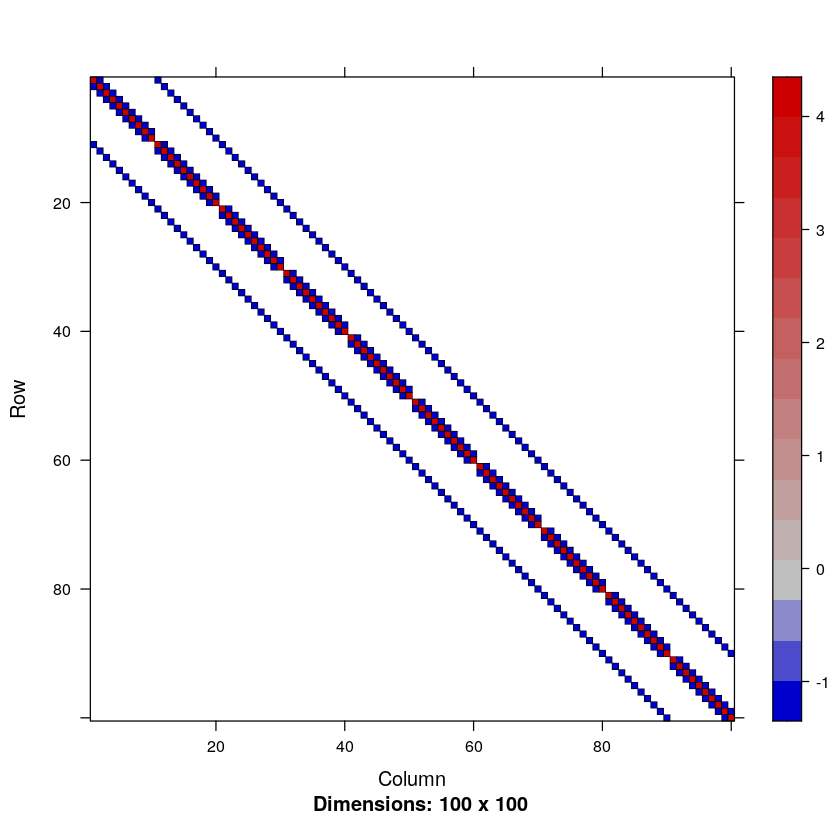

In [10]:
# Discretized Laplacian (differential operator)
## Inputs :  
## Nx : number of points in direction x
## Ny : number of points in direction y
## dx : lag in direction x
## dy : lag in direction y
## Results :
## Sparse matrix with size (Nx*Ny)x(Nx*Ny) 

DiffOperator<-function(Nx,Ny,dx,dy, kappa){
  
  nbNodes=Nx*Ny
  indices=1:nbNodes
  

  # We start by creating an array containing the indices of the non-zero elements
  # of A with associated values and we will use the R function sparseMatrix 
  # to create A from this array

  # Right neighbour ( !! remove last column)
  indicesVoisins=indices[-which(indices%%Nx==0)]
  # Matrix values
  k1=cbind(indicesVoisins,indicesVoisins+1, -1/dx^2)
  
  # Left neighbour ( !! remove first column)
  indicesVoisins=indices[-which(indices%%Nx==1)]
  # Matrix values
  k2=cbind(indicesVoisins,indicesVoisins-1, -1/dx^2)
  
  # Top neighbour  ( !! remove last line )
  indicesVoisins=indices[-which(indices>(Ny-1)*Nx)]
  # Matrix values
  k3=cbind(indicesVoisins,indicesVoisins+Nx, -1/dy^2)
  
  # Bottom neighbour ( !! remove first line )
  indicesVoisins=indices[-which(indices<Nx+1)]
  # Matrix values
  k4=cbind(indicesVoisins,indicesVoisins-Nx, -1/dy^2)
  
  # Central point
  k5=cbind(indices,indices,kappa^2+2*(1/dx^2+1/dy^2))

  # Stack all neighbours
  k=rbind(k1,k2,k3,k4,k5)
  
  # Create sparseMatrix
  return(sparseMatrix(i=k[,1],j=k[,2],x=k[,3],dims = c(nbNodes,nbNodes)))
  
}

# Test function
A=DiffOperator(10,10,1,1,0)
image(A)

## II.2 Run a simulation

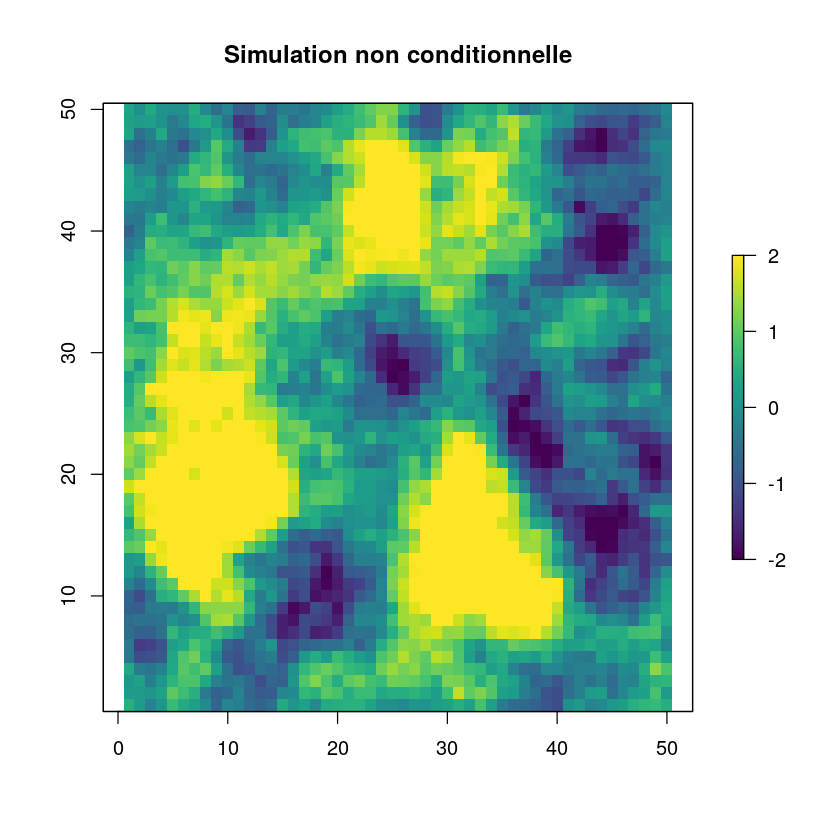

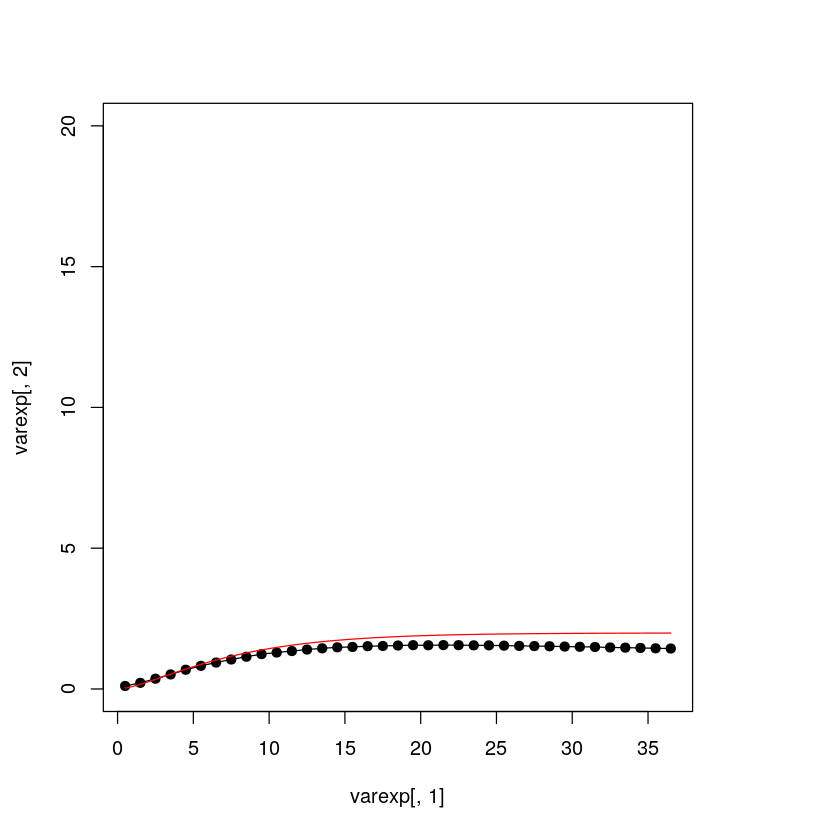

In [14]:
############  QUESTION 5  ############ 

# Raster-based image plot
spplot<-function(U,zlim,title){
  U[U<=zlim[1]]=zlim[1]
  U[U>=zlim[2]]=zlim[2]
  ras=raster(list(x=1:Nx,y=1:Ny,z=matrix(U,Nx)),crs=NA)
  plot(ras,col=viridis(128),zlim=zlim)
  title(title)
}

#### Paramètres de simulation
######## Taille du domaine
resolution=5
Nx=Ny=10*resolution;
nbNodes=Nx*Ny
######## Espace entre les noeuds
dx=dy=1;
######## Paramètre kappa
kappa=1/5;


#### Matrice de discrétisation du Laplacien
A=DiffOperator(Nx,Ny,dx,dy,kappa)


# ----------------------------------------------------------------------------------------- #

#### Fonction retournant une simulation non conditionnelle d'un vecteur gaussien
#### Argument(s) :  
######## A : Matrice de discrétisation de l'opérateur différentiel
######## dx,dy : pas de la grille de travail
#### Résultat :
######## Vecteur gaussien solution de l'EDPS discrétisée
simuNC<-function(A,dx,dy,alpha){
  if (alpha==2) {
    A = t(A)%*%A
  }
  nbNodes=dim(A)[1]
  eps=(1/sqrt(dx*dy))*rnorm(nbNodes,0,1)
  zc=solve(A,eps)
  return(zc)
  
}

# ---------------------TP_SPDE_torch.ipynb-------------------------------------------------------------------- #


#### Simulation non conditionnelle
Z = simuNC(A,dx,dy,1)
######## Affichage de la simulation
spplot(matrix(Z,nrow = Nx,ncol = Ny),zlim=c(-2,2),title="Simulation non conditionnelle")


#### Comparaison avec un Champ de Matérn
######## Paramètres  du champ
d=2     # dimension du champ
alpha=2     # degré de l'opérateur différentiel
######### Fonction retournant le variogramme de Matérn
Matern<-function(x,alpha,kappa,d){
  nu=alpha-d/2     # paramètre de forme du champ Matérn associé
  sig2=gamma(nu)/(gamma(nu+d/2)*((4*pi)^(d/2))*(kappa^(2*nu)))     # Variance du champ Matérn associé
  sig2*(1-(2^(1-nu)/gamma(nu))*(kappa*x)^(nu)*besselK(kappa*x,nu))
}
######### Calcul de la moyenne sur plusieurs simulations du variogramme expérimental
nbSim=100       # nombre de simulations
n0=0.2*(Nx*Ny)  # nombre de points sélectionnés dans une simulation pour le calcul du variogramme expérimental
lag=1           # Pas du variogramme
nbpts=0.75*Nx/lag # nombre de points du variogramme
varexp=0
for(i in 1:nbSim){
  Z0 = simuNC(A,dx,dy,1)
  varexp=varexp+expVar(Z0,n0=n0,lag = lag, nbpts =nbpts,Nx,Ny,dx,dy)/nbSim
}
rm(Z0)
######### Affichage du variogramme
plot(varexp[,1],varexp[,2],type="o", ylim=c(0, 20),pch=19)
curve(Matern(x,alpha,kappa,d),add=TRUE,col="red")

## II.3 Kriging

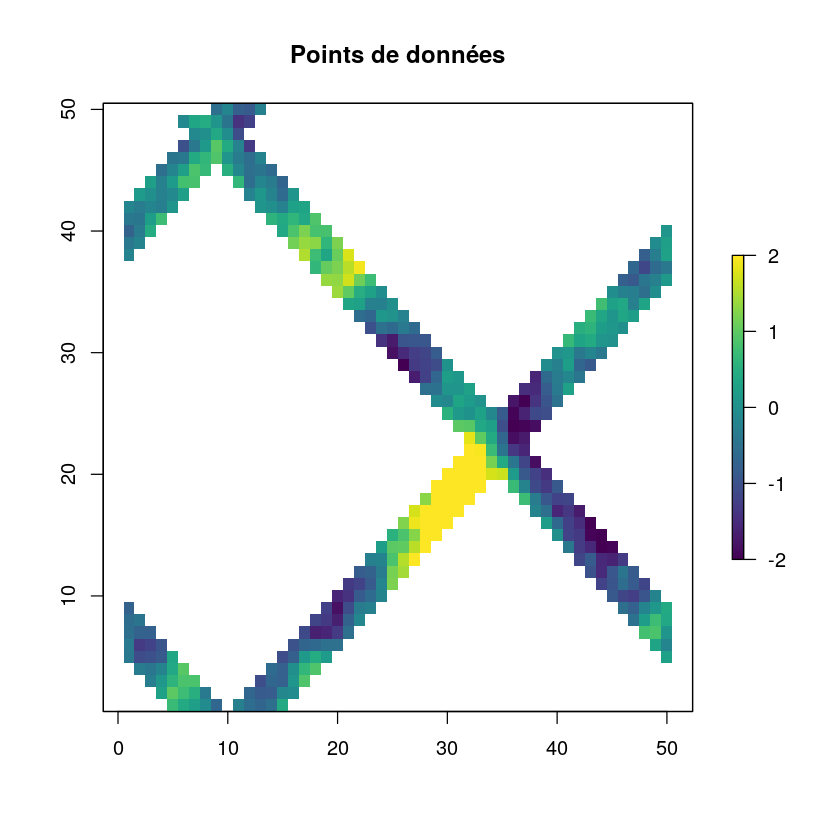

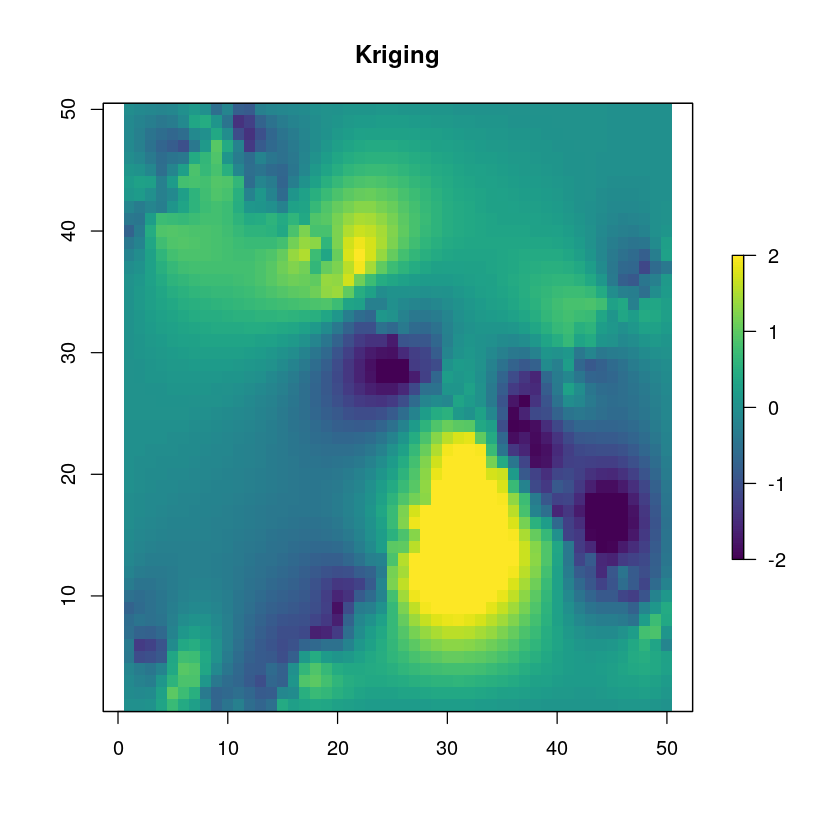

In [16]:
############  QUESTION 8  ############ 

#### Echantillonage de la simulation non conditionnelle précédente
######### Indices des points de données (D)
#indexes_dat=sample(Nx*Ny,size=20)
#indexes_dat=c(1:3000,runif(200,min=3001,max=Nx*Ny))
indexes_dat=NULL
for (j in 1:Ny){
    indexes_dat=c(indexes_dat,((Nx*(j-1))+10+j):(((Nx*(j-1))+10+j)+4))
    indexes_dat=c(indexes_dat,((Nx*(j-1))+10-j):(((Nx*(j-1))+10-j)-4))
}
indexes_dat=unique(indexes_dat[which(indexes_dat<=(Nx*Ny) & indexes_dat>0)])
######### Indices des cibles (T)
indexes_tar = setdiff(1:(Nx*Ny),indexes_dat)
######### Vecteur contenant les données (ZD)
dat=Z[indexes_dat]
######### Affichage des points de données 
datPts=rep(NA,Nx*Ny)
datPts[indexes_dat]=dat
spplot(matrix(datPts,Nx),title="Points de données",zlim=c(-2,2))

# ----------------------------------------------------------------------------------------- #

#### Calcul de la matrice de précision Q
Q=(dx*dy)*t(A)%*%A

  
#### Sous-matrices QTD de la matrice de précision
QTD=Q[indexes_tar,indexes_dat]
  
#### Calcul de la factorisation de Cholesky de QTT
#### On utilisera la fonction Cholesky du package Matrix, et on autorisera les permutations
VTT = Cholesky(Q[indexes_tar,indexes_tar],perm=TRUE,LDL=FALSE)
# ----------------------------------------------------------------------------------------- #
  
  
#### Nettoyage (suppression de la matrice de précision Q)
rm(Q)

# ----------------------------------------------------------------------------------------- #

#### Fonction retournant le krigeage des composantes d'un vecteur Gaussien
#### Argument(s) :  
######## VTT : décomposition de Cholesky de la sous matrice QTT de la matrice de précision Q du vecteur gaussien
######## QTD : sous matrice QTD de la matrice de précision Q du vecteur gaussien
######## dat : valeurs à kriger
######## indexes_dat : indices des composantes à kriger
#### Résultat :
######## Vecteur contenant les valeurs à kriger et les valeurs krigées
krig_Chol<-function(VTT, QTD,dat,indexes_dat){
  #### Calcul du second membre
  RM=-QTD%*%dat
  #### Permutation
  RM=expand(VTT)$P%*%RM
  #### Résolution du premier système linéaire
  zT_k =solve(VTT,RM,system="L")
  #### Résolution du second système linéaire
  zT_k =solve(VTT,zT_k,system="Lt")
  #### Permutation inverse
  zT_k = t(expand(VTT)$P)%*%zT_k
  #### Mise en forme du vecteur
  nbNodes=dim(QTD)[1]+dim(QTD)[2]
  z_k=rep(NA,nbNodes)
  z_k[indexes_dat]=dat
  z_k[-indexes_dat]=zT_k
  return(z_k)
}

# ----------------------------------------------------------------------------------------- #

#### Krigeage
z_k=krig_Chol(VTT,QTD,dat,indexes_dat)
######### Affichage du résultat
spplot(matrix(z_k,Nx),title="Kriging",zlim=c(-2,2))

## II.4 Conditional simulation

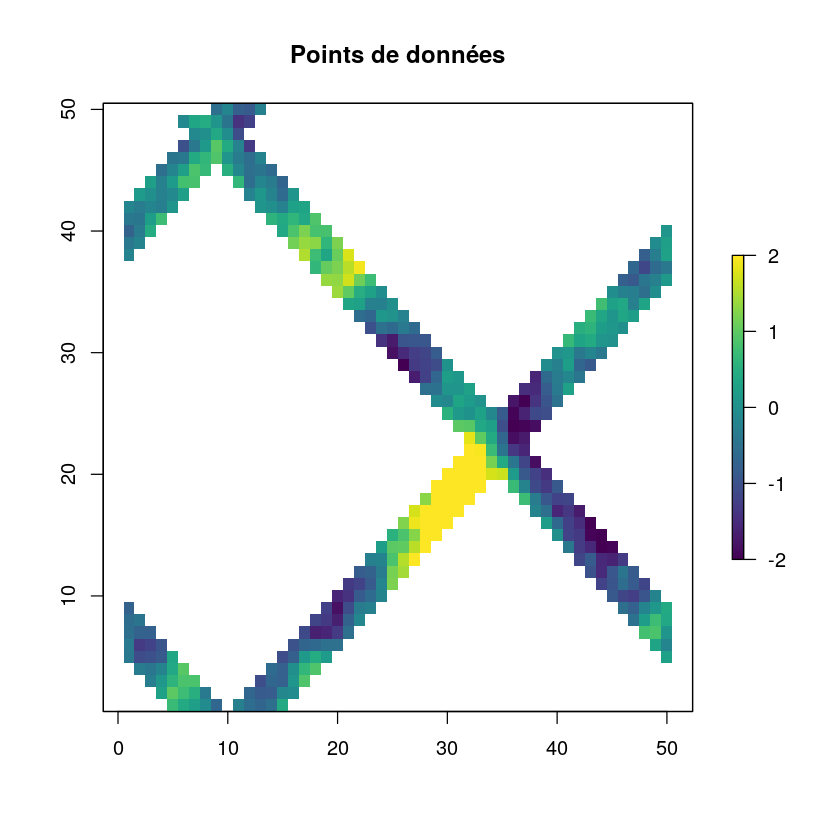

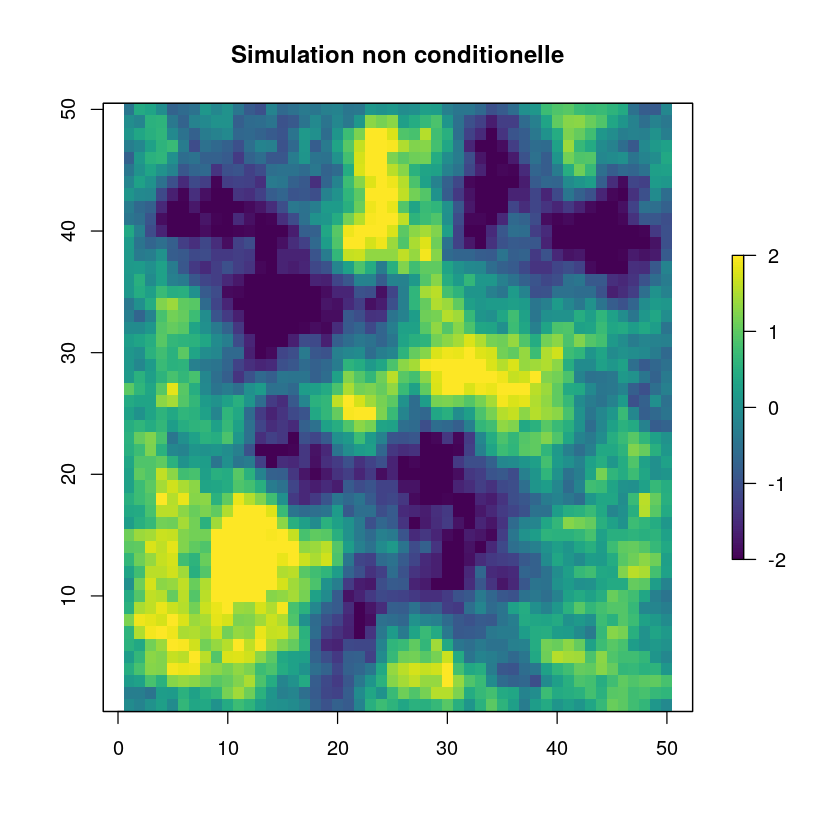

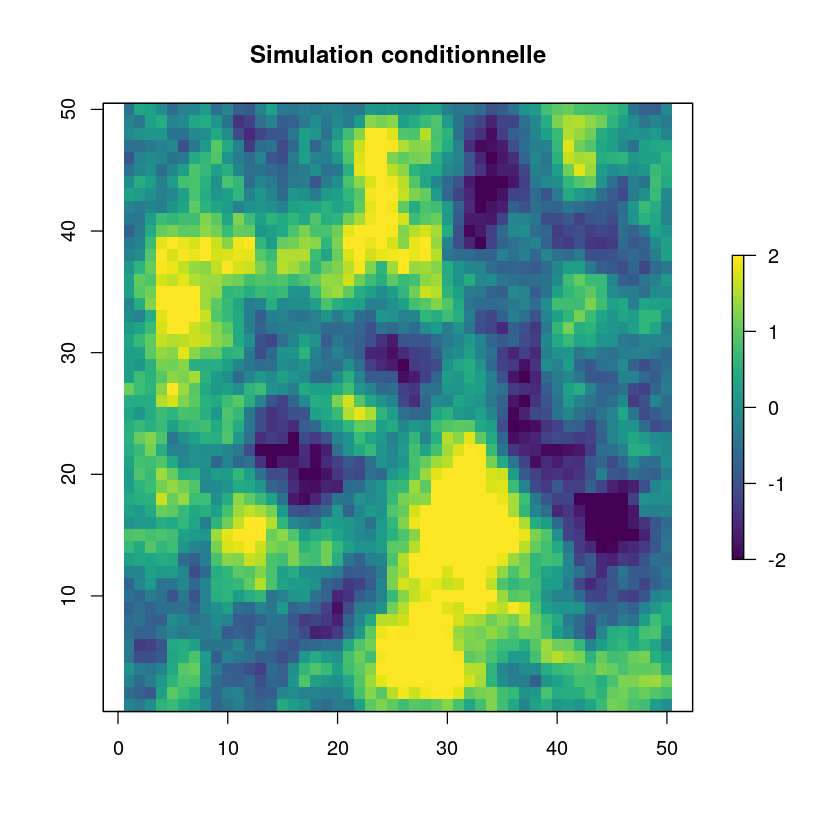

In [18]:
############  QUESTION 9  ############ 
# ----------------------------------------------------------------------------------------- #

#### Généner une simulation non conditionnelle
znc=simuNC(A,dx,dy,1)
#### Krigeage de la simulation non conditionnelle
znc_k=krig_Chol(VTT,QTD,znc[indexes_dat],indexes_dat)
#### Simulation conditionnelle
zc=z_k+(znc-znc_k)
# ----------------------------------------------------------------------------------------- #
  
######### Affichage du résultat
spplot(matrix(datPts,Nx),title="Points de données",zlim=c(-2,2))
spplot(matrix(znc,Nx),title="Simulation non conditionelle",zlim=c(-2,2))
spplot(matrix(zc,Nx),title="Simulation conditionnelle",zlim=c(-2,2))

# III. Spatio-temporal extension

## III.1 Isotropy

### III.1.a DF Discretized Laplacian

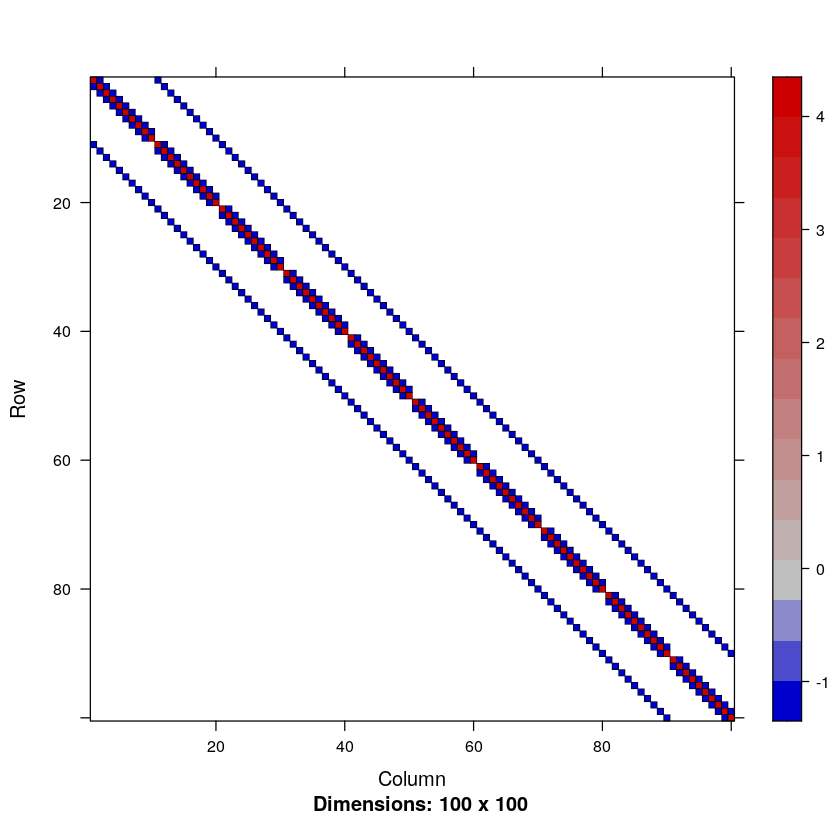

In [19]:
# Discretized Laplacian (differential operator)
## Inputs :  
## Nx : number of points in direction x
## Ny : number of points in direction y
## dx : lag in direction x
## dy : lag in direction y
## Results :
## Sparse matrix with size (Nx*Ny)x(Nx*Ny) 

DiffOperator<-function(Nx,Ny,dx,dy, kappa){
  
  nbNodes=Nx*Ny
  indices=1:nbNodes
  

  # We start by creating an array containing the indices of the non-zero elements
  # of A with associated values and we will use the R function sparseMatrix 
  # to create A from this array

  # Right neighbour ( !! remove last column)
  indicesVoisins=indices[-which(indices%%Nx==0)]
  # Matrix values
  k1=cbind(indicesVoisins,indicesVoisins+1, -1/dx^2)
  
  # Left neighbour ( !! remove first column)
  indicesVoisins=indices[-which(indices%%Nx==1)]
  # Matrix values
  k2=cbind(indicesVoisins,indicesVoisins-1, -1/dx^2)
  
  # Top neighbour  ( !! remove last line )
  indicesVoisins=indices[-which(indices>(Ny-1)*Nx)]
  # Matrix values
  k3=cbind(indicesVoisins,indicesVoisins+Nx, -1/dy^2)
  
  # Bottom neighbour ( !! remove first line )
  indicesVoisins=indices[-which(indices<Nx+1)]
  # Matrix values
  k4=cbind(indicesVoisins,indicesVoisins-Nx, -1/dy^2)
  
  # Central point
  k5=cbind(indices,indices,kappa^2+2*(1/dx^2+1/dy^2))

  # Stack all neighbours
  k=rbind(k1,k2,k3,k4,k5)
  
  # Create sparseMatrix
  return(sparseMatrix(i=k[,1],j=k[,2],x=k[,3],dims = c(nbNodes,nbNodes)))
  
}

# Test function
A=DiffOperator(10,10,1,1,0)
image(A)

### III.1.b Run the simulation

In [20]:
# Simulation parameter
#### Matrice de discrétisation du Laplacien
A=DiffOperator(Nx,Ny,dx,dy,kappa)

# Total time of the simulation
tps=100
# Time step
dt=1
# Number of steps
nbIter=tps/dt


#### Cholesky decomposition of A
AspChol=Cholesky(Diagonal(nbNodes)+dt*A%*%A,perm=TRUE,LDL=FALSE)

#### Initialisation with random values
Z=rep(0,nbNodes)
if(!file.exists("./spplots")) dir.create("./spplots")
png("./spplots/frame%03d.png")
par(ask = FALSE)
for(i in 1:nbIter){ 
  ## Second member
  RM=sqrt(dt/(dx*dy))*rnorm(nbNodes)+Z
  ## Permutation
  RM=(expand(AspChol)$P)%*%RM
  ## Solve first Linear system
  Z=solve(AspChol, RM,system="L")
  ## Solve second Linear system
  Z=solve(AspChol, Z,system="Lt")
  ## Inverse Permutation
  Z=t(expand(AspChol)$P)%*%Z
  ## Display
  spplot(Z,zlim=c(-2,2),title=paste0("Time: t =",i*dt))
}
dev.off()
png_files <- sprintf("./spplots/frame%03d.png", 1:nbIter)
gif_file <- tempfile(tmpdir='.',fileext = ".gif")
gifski(png_files, gif_file,delay=.1)

print(gif_file)
display_html(paste0('<iframe src="',gif_file,'"  width=500, height=500></iframe>')) 

png 
  2

Frame 100 (100%)
Finalizing encoding... done!


[1] "./file21c36af0319f.gif"

[1] "./file21c36af0319f.gif"


## III.2 Global anisotropy

\begin{eqnarray*}
(\kappa^2-\nabla \cdot H\nabla)^{\frac{\alpha}{2}}\mathbf{x}(\mathbf{s})=\tau\mathcal{W}(\mathbf{s})
\end{eqnarray*}

### III.2.a DF Discretized Laplacian

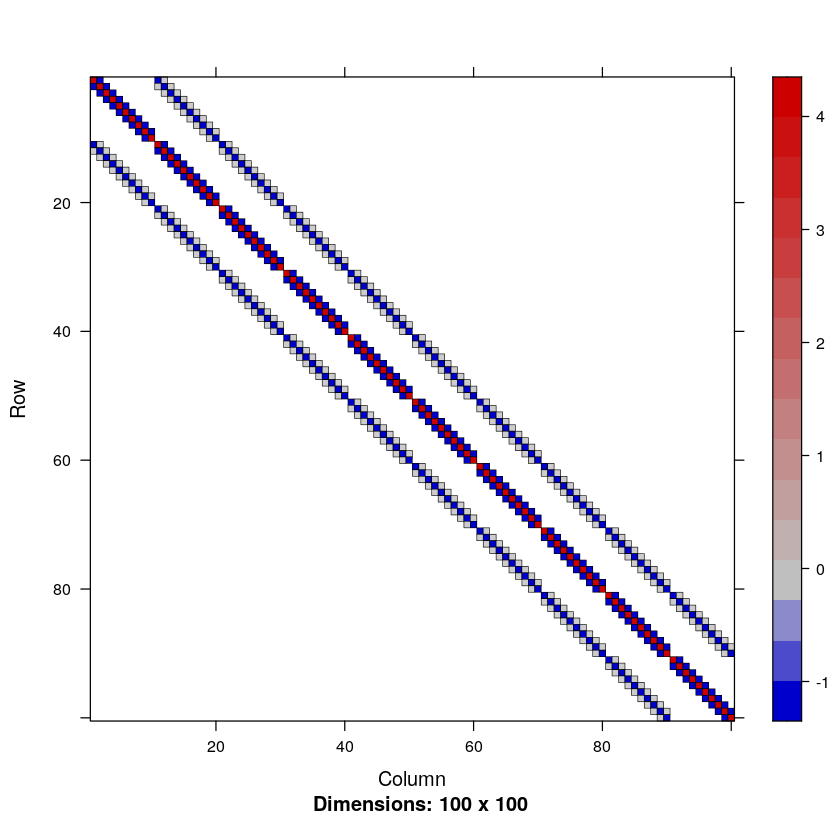

In [119]:
DiffOperator2<-function(Nx,Ny,dx,dy,H,kappa){
  
  H11=H[1,1] ; H12=H[1,2] ; H21=H[2,1] ; H22=H[2,2]  
  nbNodes=Nx*Ny
  indices=1:nbNodes
  
  # On commencera par créer un tableau contenant les indices des éléments 
  # non nuls de A ainsi que leur valeur et on utilisera la fonction 
  # sparseMatrix afin de créer A à partir de ce tableau
  
  #### Voisin à droite
  ######## Points de la grille concernés : Retrait du bord droit
  indicesVoisins=indices[-which(indices%%Nx==0)]
  ######## Elements de la matrice
  k1=cbind(indicesVoisins,indicesVoisins+1, -H11/(dx^2))
  
  #### Voisin à gauche
  ######## Points de la grille concernés : Retrait du bord gauche
  indicesVoisins=indices[-which(indices%%Nx==1)]
  ######## Elements de la matrice
  k2=cbind(indicesVoisins,indicesVoisins-1, -H11/(dx^2))

  #### Voisin du haut
  ######## Points de la grille concernés : Retrait du bord haut
  indicesVoisins=indices[-which(indices>(Ny-1)*Nx)]
  ######## Elements de la matrice
  k3=cbind(indicesVoisins,indicesVoisins+Nx, -H22/(dy^2))
  
  #### Voisin du bas
  ######## Points de la grille concernés : Retrait du bord bas
  indicesVoisins=indices[-which(indices<(Nx+1))]
  ######## Elements de la matrice
  k4=cbind(indicesVoisins,indicesVoisins-Nx, -H22/(dy^2))
        
  #### Voisin en haut à droite
  ######## Points de la grille concernés : Retrait du bord haut et droit
  indicesVoisins=indices[-which(indices%%Nx==0 | indices>(Ny-1)*Nx)]
  ######## Elements de la matrice
  k5=cbind(indicesVoisins,indicesVoisins+Nx+1, (H12+H21)/(4*dx*dy))
  
  #### Voisin en haut à gauche
  ######## Points de la grille concernés : Retrait du bord haut et gauche
  indicesVoisins=indices[-which(indices%%Nx==1  | indices>(Ny-1)*Nx)]
  ######## Elements de la matrice
  k6=cbind(indicesVoisins,indicesVoisins+Nx-1, -(H12+H21)/(4*dx*dy))

  #### Voisin en bas à droite
  ######## Points de la grille concernés : Retrait du bord bas et droit
  indicesVoisins=indices[-which(indices%%Nx==0 | indices<Nx+1)]
  ######## Elements de la matrice
  k7=cbind(indicesVoisins,indicesVoisins-Nx+1, -(H12+H21)/(4*dx*dy))
  
  #### Voisin en bas à gauche
  ######## Points de la grille concernés : Retrait du bord bas et gauche
  indicesVoisins=indices[-which(indices%%Nx==1 | indices<Nx+1)]
  ######## Elements de la matrice
  k8=cbind(indicesVoisins,indicesVoisins-Nx-1, (H12+H21)/(4*dx*dy))
    
  #### Point central
  k9=cbind(indices,indices,kappa^2+2*(H11/(dx^2)+H22/(dy^2)))
    
  #### Tous les voisins
  k=rbind(k1,k2,k3,k4,k5,k6,k7,k8,k9)
  
  return(sparseMatrix(i=k[,1],j=k[,2],x=k[,3],dims = c(nbNodes,nbNodes)))
  
}

# ----------------------------------------------------------------------------------------- #

#### Test de la fonction
A=DiffOperator2(10,10,1,1,H=matrix(c(1,0,0,1),nrow=2),0)
image(A)

### III.2.b Run the simulation

In [23]:
A=DiffOperator2(Nx,Ny,dx,dy,H=matrix(c(5,2,2,1),nrow=2),kappa)

######## Temps total de la simulation
tps=100
######## Pas de temps
dt=1
######## Nombre d'itérations
nbIter=tps/dt
######## Nombre d'itérations à sauter entre deux affichages
nbSkip=1

# ----------------------------------------------------------------------------------------- #

#### Décomposition de Cholesky de la matrice du système linéaire
#AspChol=Cholesky(Diagonal(nbNodes)+dt*A%*%A,perm=TRUE,LDL=FALSE)
AspChol=Cholesky(Diagonal(nbNodes)+dt*A%*%A,perm=TRUE,LDL=FALSE)

#### Initialisation
#Z=rep(0,nbNodes)
Z=as.vector(z_k)
if(!file.exists("./spplots")) dir.create("./spplots")
png("./spplots/frame%03d.png")
par(ask = FALSE)
Z_all = matrix(NA,nrow=nbIter, ncol=nbNodes)
for(i in 1:nbIter){ 
  #### Calcul du second membre
  RM=sqrt(dt/(dx*dy))*rnorm(nbNodes,0,1)+Z
  #### Permutation
  RM=(expand(AspChol)$P)%*%RM
  #### Résolution du premier système linéaire
  Z=solve(AspChol, RM,system="L")
  #### Résolution du second système linéaire
  Z=solve(AspChol, Z,system="Lt")
  #### Permutation inverse
  Z=t(expand(AspChol)$P)%*%Z
  #### Affichage
  Z_all[i,]=Z
  ## Display
  spplot(Z,zlim=c(-2,2),title=paste0("Time: t =",i*dt))
}
dev.off()
png_files <- sprintf("./spplots/frame%03d.png", 1:nbIter)
gif_file <- tempfile(tmpdir='.',fileext = ".gif")
gifski(png_files, gif_file,delay=.1)

print(gif_file)
display_html(paste0('<iframe src="',gif_file,'"  width=500, height=500></iframe>'))

png 
  2

Frame 100 (100%)
Finalizing encoding... done!


[1] "./file21c332cd2e97.gif"

[1] "./file21c332cd2e97.gif"


### III.2.c Generating a spatio-temporal dataset 

In [26]:
Z_data_all=Z_all
idD=vector(mode = "list", length = nbIter)
if(!file.exists("./spplots")) dir.create("./spplots")
png("./spplots/frame%03d.png")
par(ask = FALSE)
for(i in 1:nbIter){
    indexes_dat=NULL
    for (j in 1:Ny){
        indexes_dat=c(indexes_dat,((Nx*(j-1))+10+j+(10*i%%Nx)):(((Nx*(j-1))+10+j+(10*i%%Nx)+4)))
        indexes_dat=c(indexes_dat,((Nx*(j-1))+10-j-(10*i%%Nx)):(((Nx*(j-1))+10-j-(10*i%%Nx)-4)))
    }
    indexes_dat=unique(indexes_dat[which(indexes_dat<=(Nx*Ny) & indexes_dat>0)])
    Z_data_all[i,-indexes_dat]=NA
    ## Display
    spplot(Z_data_all[i,],zlim=c(-2,2),title=paste0("Time: t =",i*dt))
    idD[[i]]=indexes_dat
}
dev.off()

png_files <- sprintf("./spplots/frame%03d.png", 1:nbIter)
gif_file <- tempfile(tmpdir='.',fileext = ".gif")
gifski(png_files, gif_file,delay=.1)

print(gif_file)
display_html(paste0('<iframe src="',gif_file,'"  width=500, height=500></iframe>'))


png 
  2

Frame 100 (100%)
Finalizing encoding... done!


[1] "./file21c3637c9a3f.gif"

[1] "./file21c3637c9a3f.gif"


### III.2.d Spatial kriging

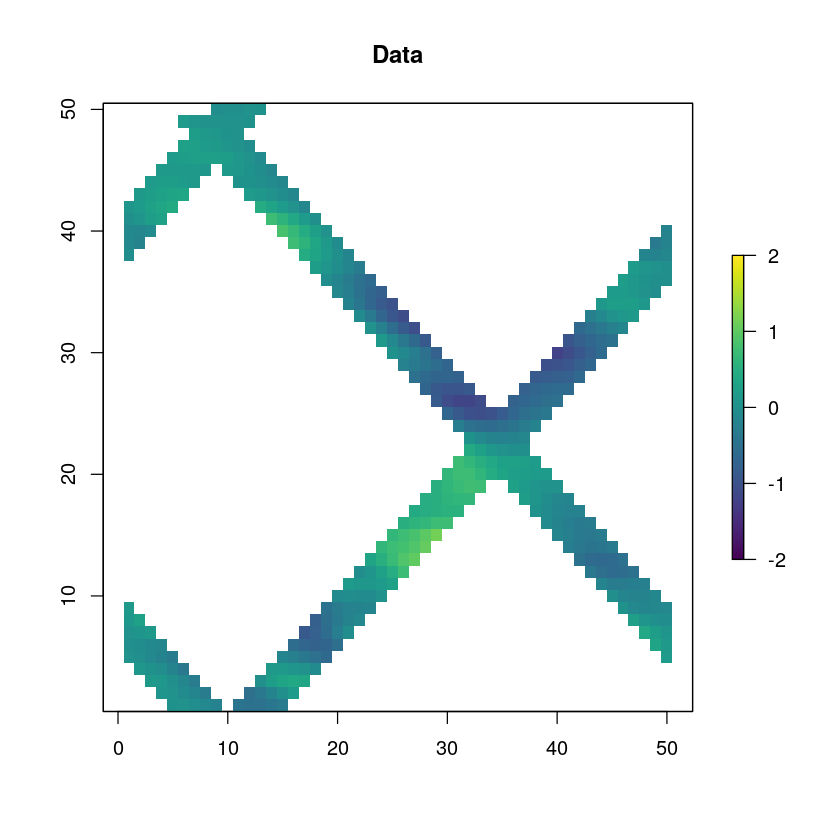

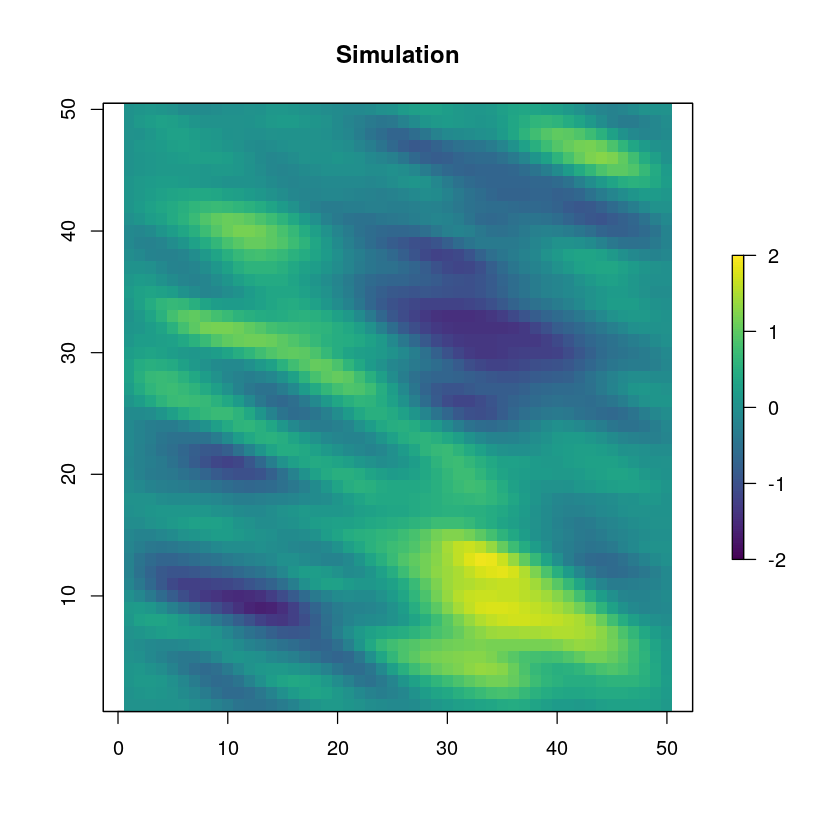

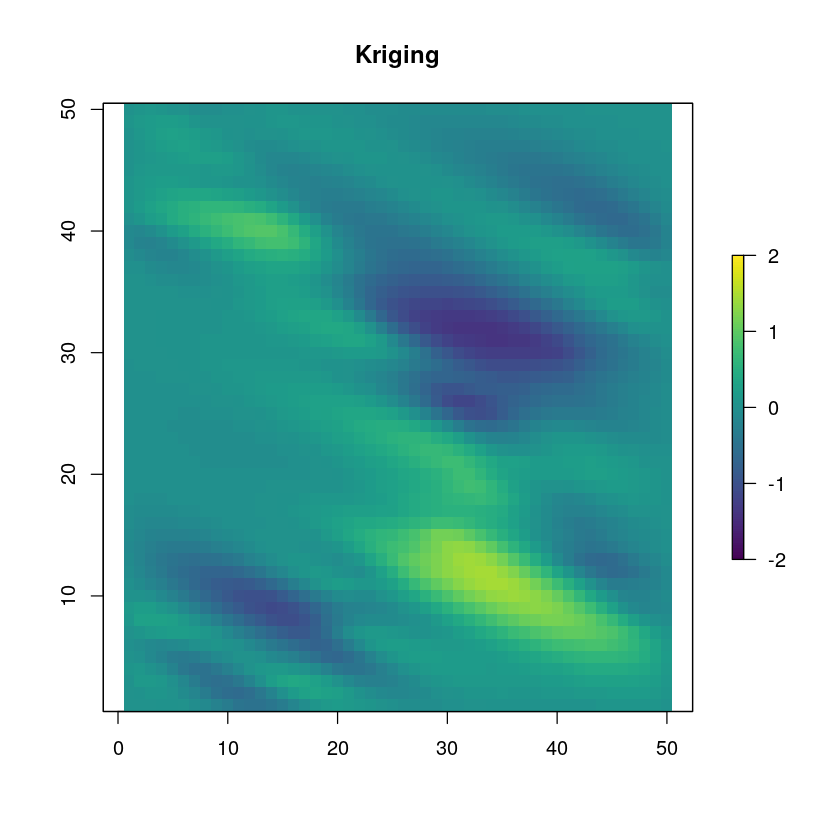

In [27]:
#### Calcul de la matrice de précision Q
Q=(dx*dy)*t(A)%*%A
Q=(dx*dy)*(1/2)*((A%*%A) + t(A%*%A))
itime=50

indexes_tar = setdiff(1:(Nx*Ny),idD[[itime]])

#### Sous-matrices QTD de la matrice de précision
QTD=Q[indexes_tar,idD[[itime]]]
#### Calcul de la factorisation de Cholesky de QTT
#### On utilisera la fonction Cholesky du package Matrix, et on autorisera les permutations
VTT = Cholesky(Q[indexes_tar,indexes_tar],perm=TRUE,LDL=FALSE)
### 
znc=Z_all[itime,]
#### Krigeage de la simulation non conditionnelle
z_k_S=krig_Chol(VTT,QTD,znc[idD[[itime]]],idD[[itime]])
dat_pts = znc
dat_pts[-idD[[itime]]]=NA
spplot(matrix(dat_pts,nrow=Nx),zlim=c(-2,2),title='Data')
spplot(matrix(znc,nrow=Nx),zlim=c(-2,2),title='Simulation')
spplot(matrix(z_k_S,nrow=Nx),zlim=c(-2,2),title='Kriging')

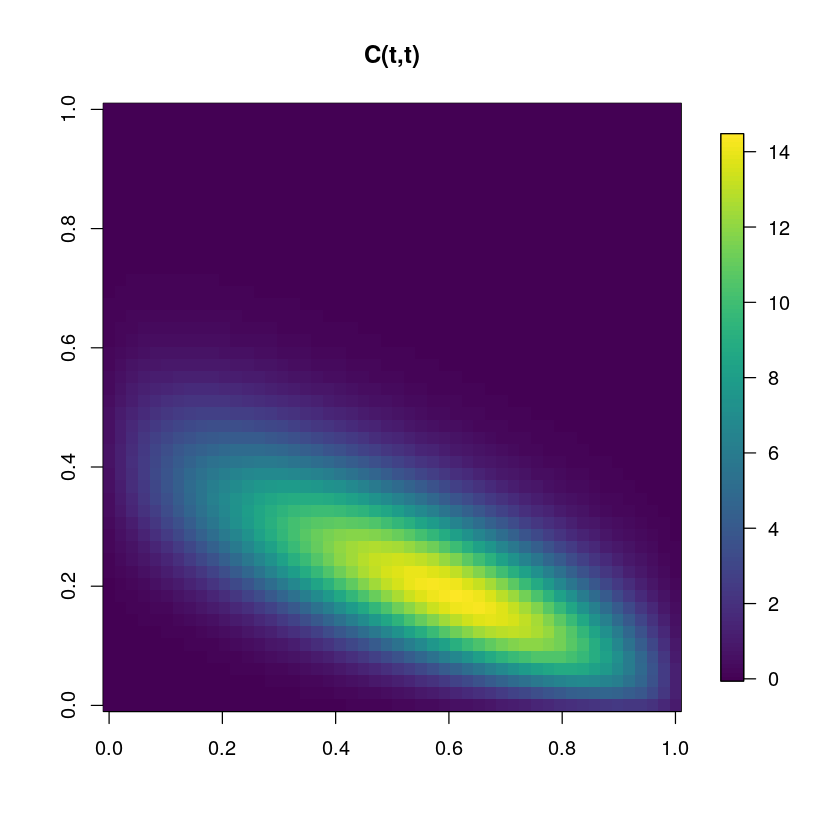

In [14]:
# display spatial covariance
Q=(dx*dy)*t((t(A)%*%A))%*%(t(A)%*%A)
image.plot(matrix(solve(Q)[100,],nrow=Nx),col=viridis(128),main="C(t,t)")

### III.2.e Spatio-temporal kriging

In [28]:
#### Calcul de la matrice de précision Q
#Q=(dx*dy)*t(A)%*%A
Q=(dx*dy)*(1/2)*((A%*%A) + t(A%*%A))
itime=50
indexes_tar = setdiff(1:(Nx*Ny),idD[[itime]])
#### Calcul de la factorisation de Cholesky de QTT
#### On utilisera la fonction Cholesky du package Matrix, et on autorisera les permutations
VTT = Cholesky(Q[indexes_tar,indexes_tar],perm=TRUE,LDL=FALSE)

dat=NULL
dat0=Z_data_all[itime,idD[[itime]]]

#Chol=Cholesky(Diagonal(nbNodes)+dt*t(A)%*%A,perm=FALSE,LDL=FALSE)
#Prod_   = solve(Diagonal(nbNodes)+dt*t(A)%*%A)
#Prod_T_ = solve(Diagonal(nbNodes)+dt*A%*%t(A))

Chol=Cholesky(Diagonal(nbNodes)+dt*(1/2)*((A%*%A) + t(A%*%A)),perm=FALSE,LDL=FALSE)
Prod_   = solve(Diagonal(nbNodes)+dt*(1/2)*((A%*%A) + t(A%*%A)))
Prod_T_ = solve(Diagonal(nbNodes)+dt*(1/2)*((A%*%A) + t(A%*%A)))

QTD=NULL
for (k in seq(-2,2,1)) {
  Prod = Diagonal(nbNodes)
  if (k<0){
    for(l in seq(k,-1)) {
        Prod = Prod %*% Prod_T_
        #Chol=Cholesky(Diagonal(nbNodes)+dt*t(A)%*%A,perm=TRUE,LDL=FALSE)
        #Prod = Prod %*% (solve(t(expand(Chol)$L),system="Lt")  %*% solve(expand(Chol)$L,system="L"))
    }
    Qk = Prod %*% Q 
  }
  else if (k>0){
    for(l in seq(k,1)){
        #Prod = Prod %*% (Diagonal(nbNodes)+dt*A%*%t(A))  
        Prod = Prod %*% Prod_
    }
    Qk =  Q %*% Prod 
  }
  else {
     Qk =  Q    
  }
  #### Sous-matrices QTD de la matrice de précision
  QTDk=Qk[indexes_tar,idD[[itime+k]]]
    
  # column-stack of QTD
  QTD= cbind(QTD,QTDk)
    
  # space-time for kriging
  dat=c(dat,Z_data_all[itime+k,idD[[itime+k]]])
}

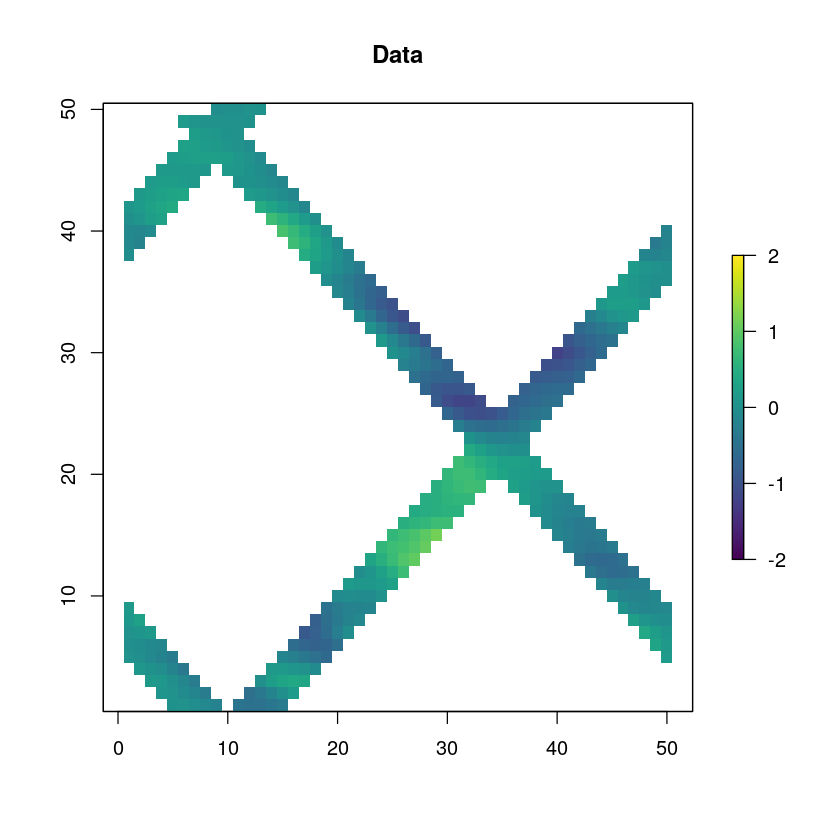

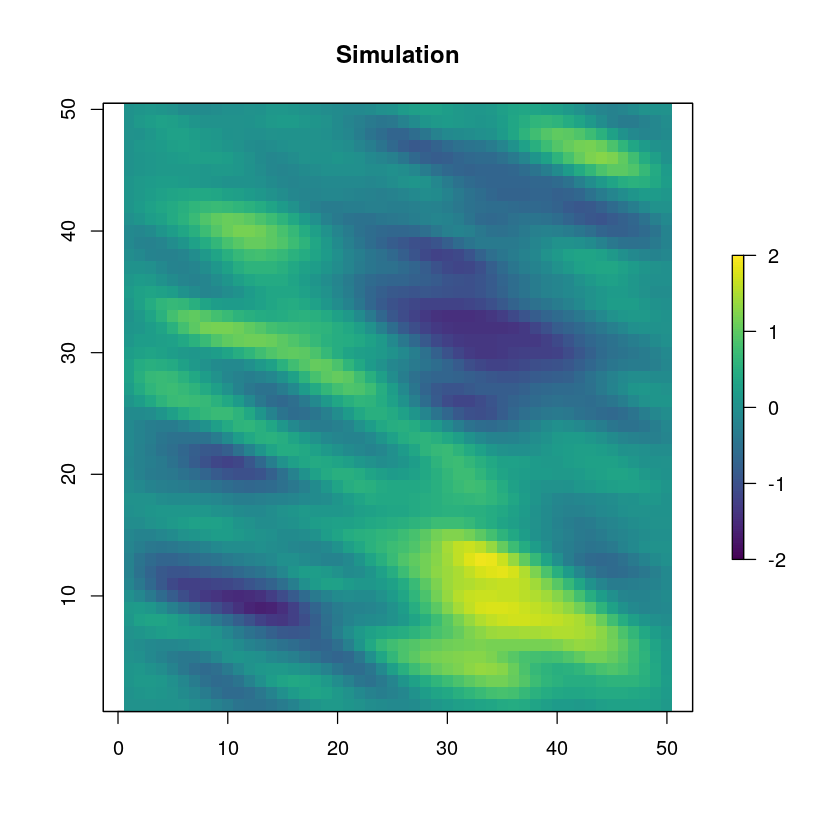

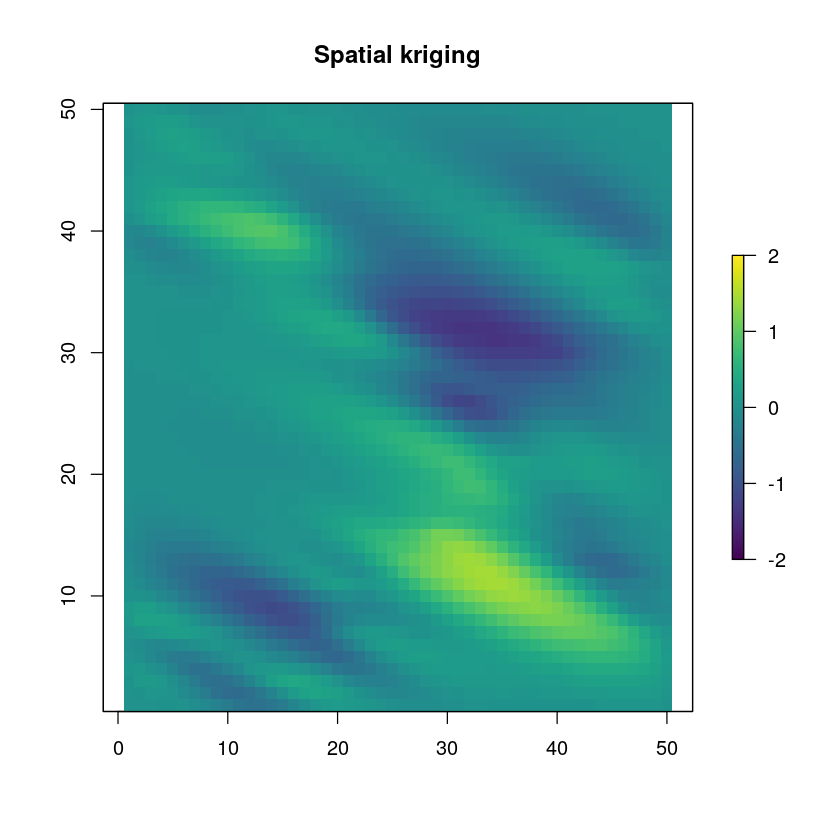

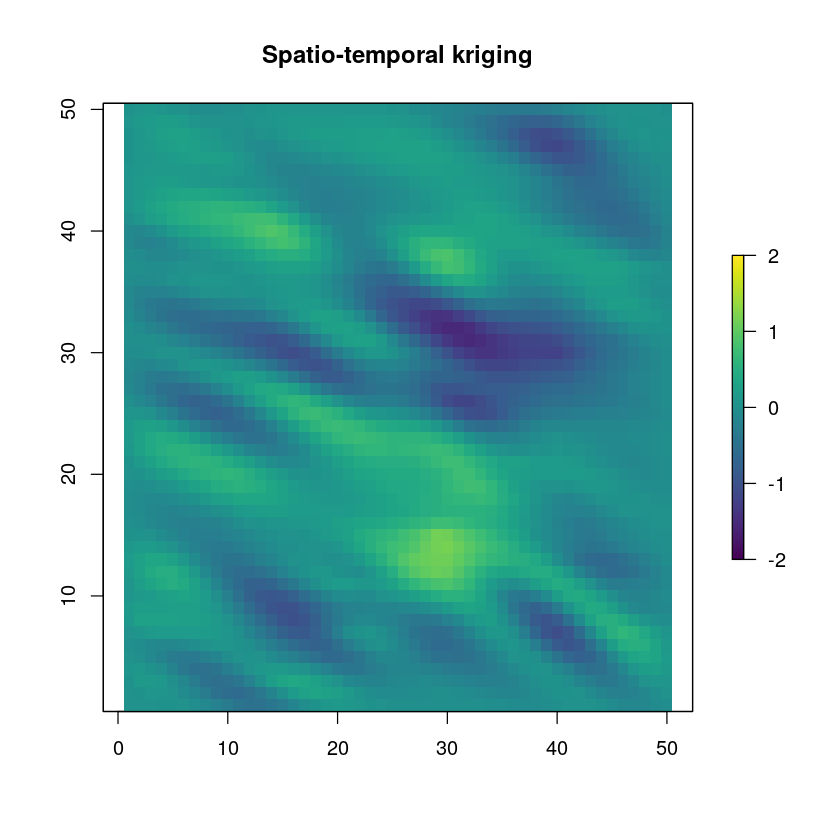

In [29]:
krig_Chol_ST<-function(VTT, QTD,dat,dat0,indexes_dat){
  #### Calcul du second membre
  RM=-QTD%*%dat
  #### Permutation
  RM=expand(VTT)$P%*%RM
  #### Résolution du premier système linéaire
  zT_k =solve(VTT,RM,system="L")
  #### Résolution du second système linéaire
  zT_k =solve(VTT,zT_k,system="Lt")
  #### Permutation inverse
  zT_k = t(expand(VTT)$P)%*%zT_k
  #### Mise en forme du vecteur
  nbNodes=dim(QTD)[1]+length(dat0)
  z_k=rep(NA,nbNodes)
  z_k[indexes_dat]=dat0
  z_k[-indexes_dat]=zT_k
  return(z_k)
}

#### Krigeage de la simulation non conditionnelle
z_k_ST=krig_Chol_ST(VTT,QTD,dat,dat0,idD[[itime]])
znc=Z_all[itime,]
spplot(matrix(Z_data_all[itime,],nrow=Nx),zlim=c(-2,2),title='Data')
spplot(matrix(znc,nrow=Nx),zlim=c(-2,2),title='Simulation')
spplot(matrix(z_k_S,nrow=Nx),zlim=c(-2,2),title='Spatial kriging')
spplot(matrix(z_k_ST,nrow=Nx),zlim=c(-2,2),title='Spatio-temporal kriging')

## III.3 Local anisotropy

\begin{eqnarray*}
(\kappa^2-\nabla \cdot H(\mathbf{s})\nabla)^{\frac{\alpha}{2}}\mathbf{x}(\mathbf{s})=\tau\mathcal{W}(\mathbf{s})
\end{eqnarray*}

### III.1.a Anisotropy field

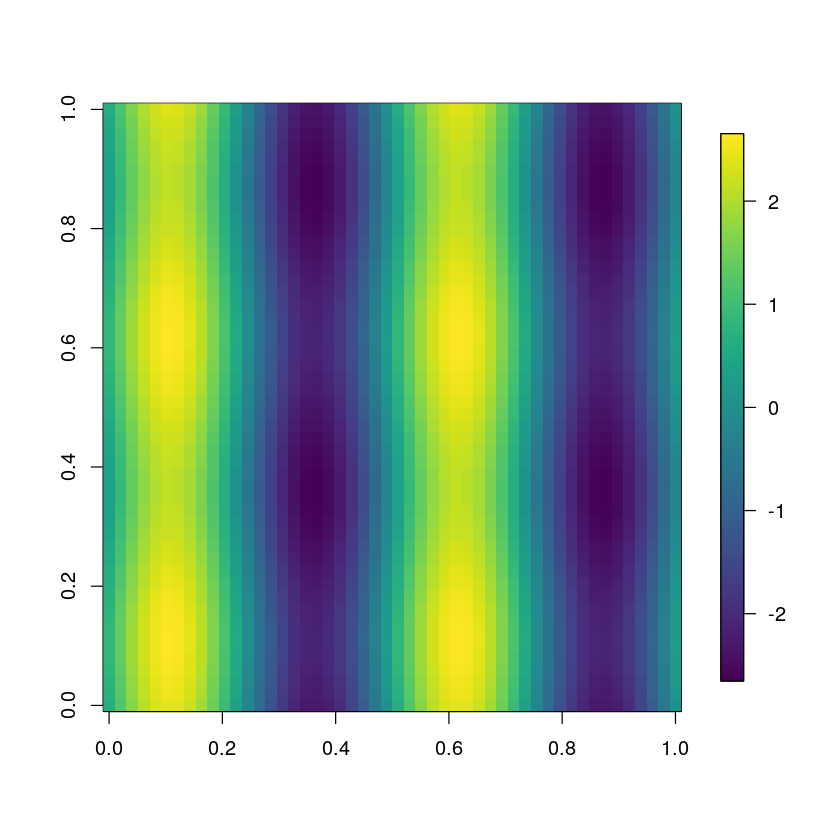

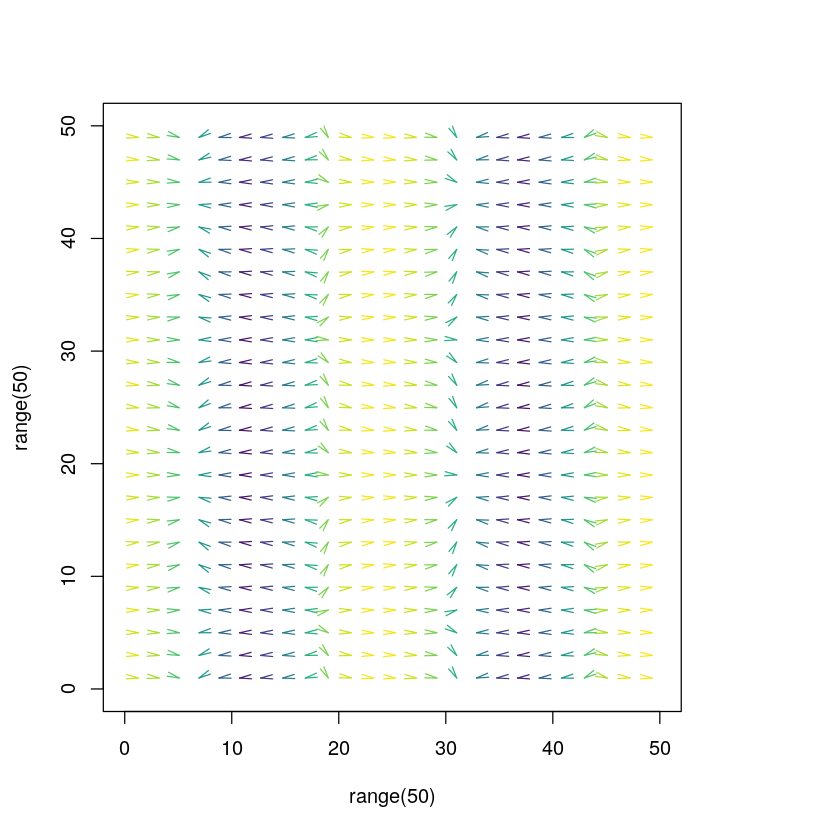

In [30]:
fxy<-function(x,y){
 return( ((2*resolution)/pi)*( (3/4)*sin(2*pi*x/(5*resolution))) + (1/4)*sin(2*pi*y/(5*resolution) ))
}
x=rep(1:Nx,Ny)
y=rep(1:Ny,each=Nx)
res=matrix(mapply(fxy,x,y),nrow=Nx)
grad=gradient(res,1,1)
u_=grad$X
v_=grad$Y
rotate_vector<-function(x1,y1,angle){
  x1 = as.vector(x1)
  y1 = as.vector(y1)
  x2=cos(angle)*x1-sin(angle)*y1
  y2=sin(angle)*x1+cos(angle)*y1
  return(cbind(x2,y2))
}
u=matrix(rotate_vector(u_,v_,-pi/2)[,1],nrow=Nx)
v=matrix(rotate_vector(u_,v_,-pi/2)[,2],nrow=Nx)
image.plot(res,col=viridis(128))
plot(range(50),range(50),type="n",xlim=c(0,Nx),ylim=c(0,Ny))
step_arrow=2
palette=viridis(128)
col=palette[floor(as.vector(sqrt(u^2+v^2)/max(sqrt(u^2+v^2)))*128)]
quiver(matrix(x,nrow=Nx)[seq(1,Nx,step_arrow),seq(1,Nx,step_arrow)],
       matrix(y,nrow=Nx)[seq(1,Ny,step_arrow),seq(1,Ny,step_arrow)],
       u[seq(1,Nx,step_arrow),seq(1,Nx,step_arrow)],
       v[seq(1,Ny,step_arrow),seq(1,Ny,step_arrow)],
       col=col,scale=0.5,length=0.1,angle=1,xlab="",ylab="",main="Vector field")

In [31]:
library(abind)
Hs<-function(u,v,gamma,beta){
  nNodes = nrow(u)*ncol(u)
  H=array(NA,dim=c(2,2,nNodes))
  cpt=1
  for(i in 1:nrow(u)){
    for(j in 1:ncol(u)){
      vs=matrix(c(u[i,j],v[i,j]),nrow=2)
      Hs=(gamma*diag(2)) + beta*(vs%*%t(vs))
      H[,,cpt]=Hs
      cpt=cpt+1
    }
  }
  return(H)
}
Hs=Hs(u,v,1,25)

\begin{eqnarray}
H(\mathbf{s})=\gamma \mathbf{I}_2 + \beta\left[\mathbf{v}(\mathbf{s}) \mathbf{v}(\mathbf{s})^\mathrm{T}\right]
\end{eqnarray}

### III.3.b DF Discretized Laplacian

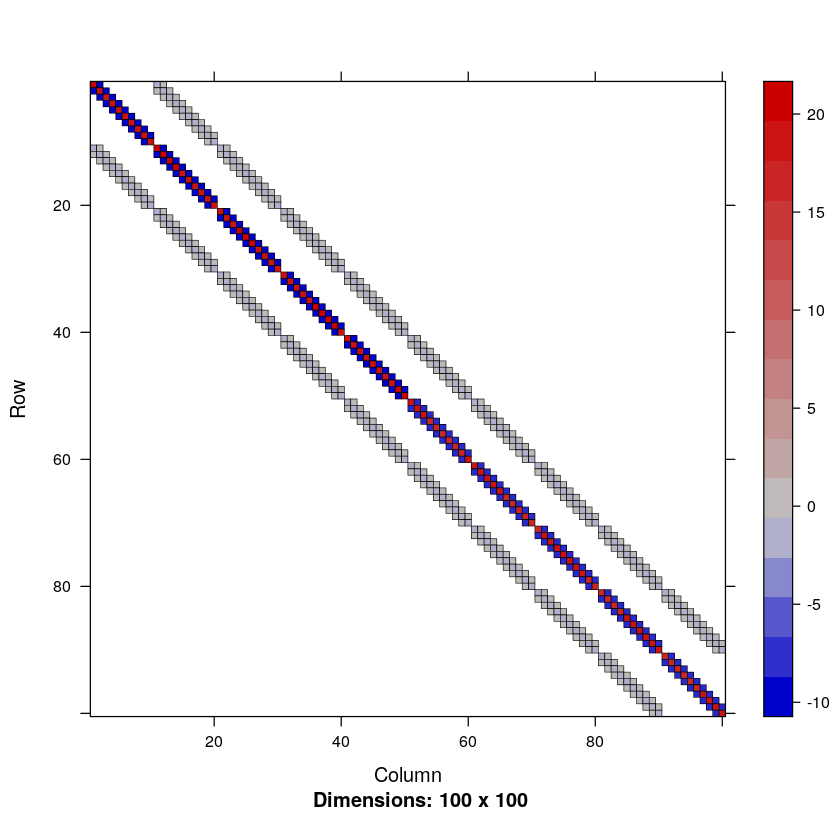

In [32]:
DiffOperator3<-function(Nx,Ny,dx,dy,H,kappa){
  
  nbNodes=Nx*Ny
  indices=1:nbNodes
  
  # On commencera par créer un tableau contenant les indices des éléments 
  # non nuls de A ainsi que leur valeur et on utilisera la fonction 
  # sparseMatrix afin de créer A à partir de ce tableau
  
  #### Voisin à droite
  ######## Points de la grille concernés : Retrait du bord droit
  indicesVoisins=indices[-which(indices%%Nx==0)]
  ######## Elements de la matrice
  k1=cbind(indicesVoisins,indicesVoisins+1, -1*(H[1,1,indicesVoisins])/(dx^2))
  
  #### Voisin à gauche
  ######## Points de la grille concernés : Retrait du bord gauche
  indicesVoisins=indices[-which(indices%%Nx==1)]
  ######## Elements de la matrice
  k2=cbind(indicesVoisins,indicesVoisins-1, -1*(H[1,1,indicesVoisins])/(dx^2))

  #### Voisin du haut
  ######## Points de la grille concernés : Retrait du bord haut
  indicesVoisins=indices[-which(indices>(Ny-1)*Nx)]
  ######## Elements de la matrice
  k3=cbind(indicesVoisins,indicesVoisins+Nx, -1*(H[2,2,indicesVoisins])/(dy^2))
  
  #### Voisin du bas
  ######## Points de la grille concernés : Retrait du bord bas
  indicesVoisins=indices[-which(indices<(Nx+1))]
  ######## Elements de la matrice
  k4=cbind(indicesVoisins,indicesVoisins-Nx, -1*(H[2,2,indicesVoisins])/(dy^2))
        
  #### Voisin en haut à droite
  ######## Points de la grille concernés : Retrait du bord haut et droit
  indicesVoisins=indices[-which(indices%%Nx==0 | indices>(Ny-1)*Nx)]
  ######## Elements de la matrice
  k5=cbind(indicesVoisins,indicesVoisins+Nx+1, H[1,2,indicesVoisins]/(2*dx*dy))
    
  #### Voisin en haut à gauche
  ######## Points de la grille concernés : Retrait du bord haut et gauche
  indicesVoisins=indices[-which(indices%%Nx==1  | indices>(Ny-1)*Nx)]
  ######## Elements de la matrice
  k6=cbind(indicesVoisins,indicesVoisins+Nx-1, -1*H[1,2,indicesVoisins]/(2*dx*dy))
    
  #### Voisin en bas à droite
  ######## Points de la grille concernés : Retrait du bord bas et droit
  indicesVoisins=indices[-which(indices%%Nx==0 | indices<Nx+1)]
  ######## Elements de la matrice
  k7=cbind(indicesVoisins,indicesVoisins-Nx+1, -1*H[1,2,indicesVoisins]/(2*dx*dy))
  
  #### Voisin en bas à gauche
  ######## Points de la grille concernés : Retrait du bord bas et gauche 
  indicesVoisins=indices[-which(indices%%Nx==1 | indices<Nx+1)]
  ######## Elements de la matrice
  k8=cbind(indicesVoisins,indicesVoisins-Nx-1, H[1,2,indicesVoisins]/(2*dx*dy))
    
  #### Point central
  k9=cbind(indices,indices,kappa^2+2*(H[1,1,indices]/(dx^2)+H[2,2,indices]/(dy^2)))
    
  #### Tous les voisins
  k=rbind(k1,k2,k3,k4,k5,k6,k7,k8,k9)
  
  return(sparseMatrix(i=k[,1],j=k[,2],x=k[,3],dims = c(nbNodes,nbNodes)))
  
}

# ----------------------------------------------------------------------------------------- #

#### Test de la fonction
A=DiffOperator3(10,10,1,1,Hs,0)
image(A)

### III.1.c Run the simulation

In [55]:
A=DiffOperator3(Nx,Ny,dx,dy,Hs,kappa=.1)
tau=1

######## Temps total de la simulation
tps=100
######## Pas de temps
dt=1
######## Nombre d'itérations
nbIter=tps/dt
######## Nombre d'itérations à sauter entre deux affichages
nbSkip=1

# ----------------------------------------------------------------------------------------- #

#### Décomposition de Cholesky de la matrice du système linéaire
#AspChol=Cholesky(Diagonal(nbNodes)+dt*(A%*%A),perm=TRUE,LDL=FALSE)
#AspChol=Cholesky(Diagonal(nbNodes)+dt*t(A)%*%A,perm=TRUE,LDL=FALSE)
AspChol=Cholesky((1/tau)*Diagonal(nbNodes)+dt*t(A)%*%A,perm=FALSE,LDL=FALSE)

#### Initialisation
Z=rnorm(nbNodes,0,tau)
Z_all = matrix(NA,nrow=nbIter, ncol=nbNodes)
#Z=as.vector(z_k)
if(!file.exists("./spplots")) dir.create("./spplots")
png("./spplots/frame%03d.png")
par(ask = FALSE)
for(i in 1:nbIter){ 
  #### Calcul du second membre
  RM=sqrt(dt/(dx*dy))*rnorm(nbNodes,0,tau)+Z
  #### Permutation
  RM=(expand(AspChol)$P)%*%RM
  #### Résolution du premier système linéaire
  Z=solve(AspChol, RM,system="L")
  #### Résolution du second système linéaire
  Z=solve(AspChol, Z,system="Lt")
  #### Permutation inverse
  Z=t(expand(AspChol)$P)%*%Z
  #### Affichage
  Z_all[i,]=Z
  spplot(Z,zlim=c(-2,2),title=paste0("Time: t =",i*dt))
}
dev.off()

png_files <- sprintf("./spplots/frame%03d.png", 1:nbIter)
gif_file <- tempfile(tmpdir='.',fileext = ".gif")
gifski(png_files, gif_file, delay=.1)

print(gif_file)
display_html(paste0('<iframe src="',gif_file,'"  width=500, height=500></iframe>'))

png 
  2

Frame 100 (100%)
Finalizing encoding... done!


[1] "./file21c3332bc09.gif"

[1] "./file21c3332bc09.gif"


### III.3.d Generating a spatio-temporal dataset 

In [56]:
Z_data_all=Z_all
idD=vector(mode = "list", length = nbIter)
if(!file.exists("./spplots")) dir.create("./spplots")
png("./spplots/frame%03d.png")
par(ask = FALSE)
for(i in 1:nbIter){
    indexes_dat=NULL
    for (j in 1:Ny){
        indexes_dat=c(indexes_dat,((Nx*(j-1))+10+j+(10*i%%Nx)):(((Nx*(j-1))+10+j+(10*i%%Nx)+4)))
        indexes_dat=c(indexes_dat,((Nx*(j-1))+10-j-(10*i%%Nx)):(((Nx*(j-1))+10-j-(10*i%%Nx)-4)))
    }
    indexes_dat=unique(indexes_dat[which(indexes_dat<=(Nx*Ny) & indexes_dat>0)])
    Z_data_all[i,-indexes_dat]=NA
    spplot(Z_data_all[i,],zlim=c(-2,2),title=paste0("Time: t =",i*dt))
    idD[[i]]=indexes_dat
}
dev.off()

png_files <- sprintf("./spplots/frame%03d.png", 1:nbIter)
gif_file <- tempfile(tmpdir='.',fileext = ".gif")
gifski(png_files, gif_file, delay=.1)

print(gif_file)
display_html(paste0('<iframe src="',gif_file,'"  width=500, height=500></iframe>'))


png 
  2

Frame 100 (100%)
Finalizing encoding... done!


[1] "./file21c3f8abdfc.gif"

[1] "./file21c3f8abdfc.gif"


### III.3.e Spatial kriging

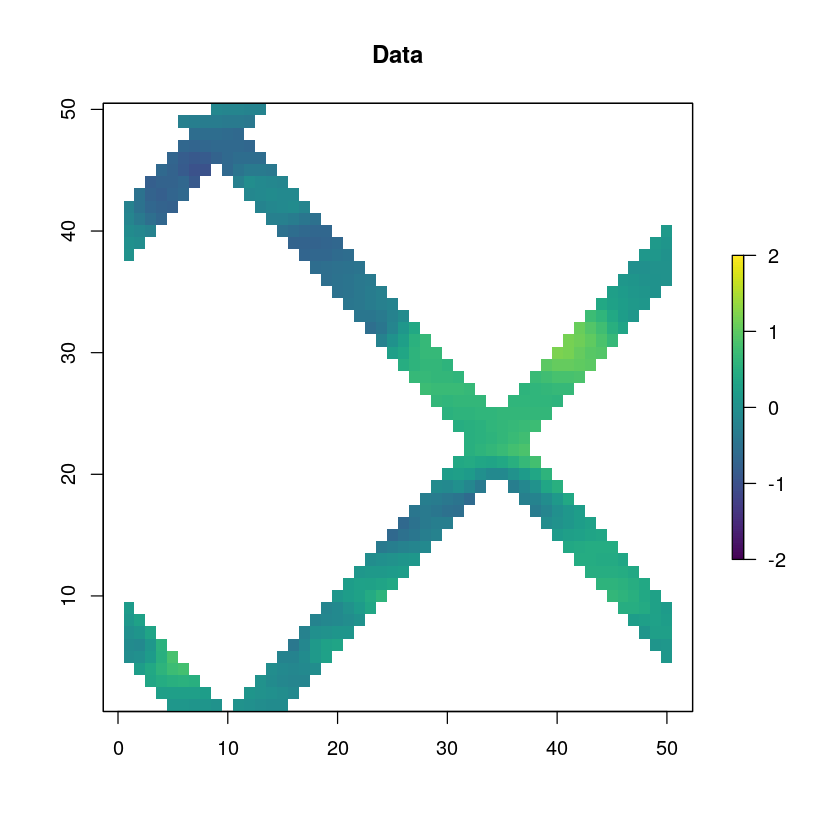

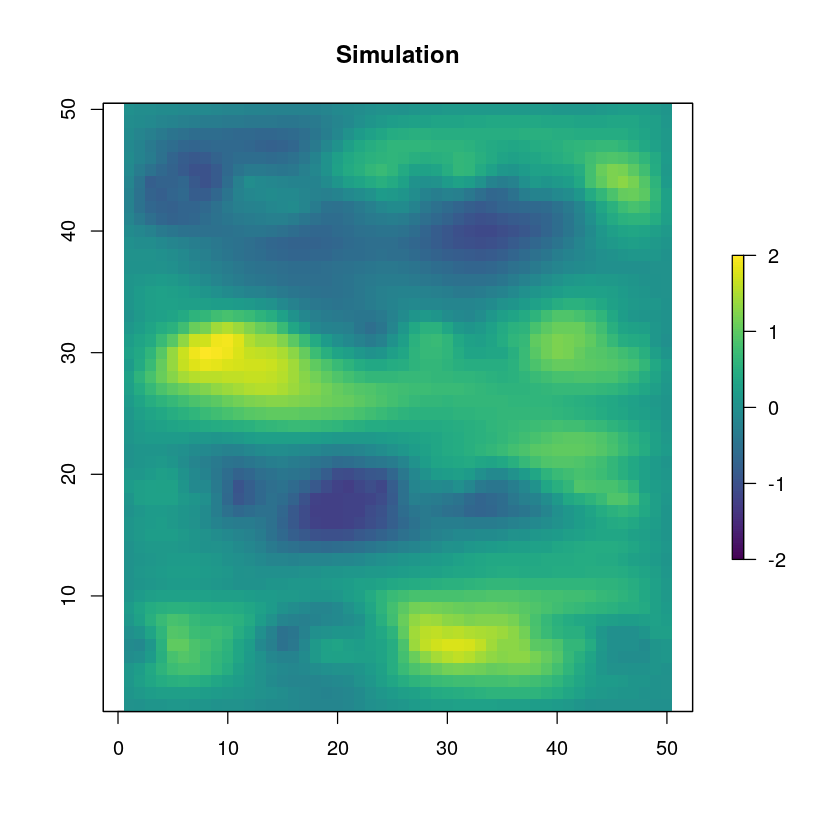

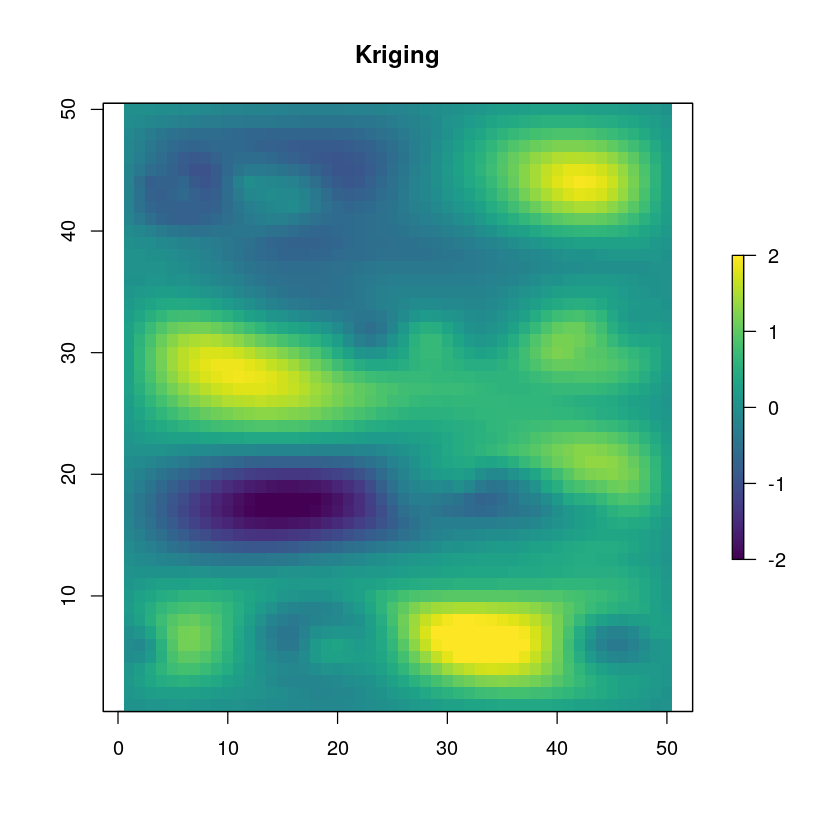

In [57]:
#### Calcul de la matrice de précision Q
Q=(dx*dy)*t(A)%*%A
Q=(dx*dy)*t((t(A)%*%A))%*%(t(A)%*%A)
#Q=(dx*dy)*(1/2)*((A%*%A) + t(A%*%A))
#Q=(dx*dy)*t((1/2)*((A%*%A) + t(A%*%A)))%*%((1/2)*((A%*%A) + t(A%*%A)))
itime=50

indexes_tar = setdiff(1:(Nx*Ny),idD[[itime]])

#### Sous-matrices QTD de la matrice de précision
QTD=Q[indexes_tar,idD[[itime]]]
#### Calcul de la factorisation de Cholesky de QTT
#### On utilisera la fonction Cholesky du package Matrix, et on autorisera les permutations
VTT = Cholesky(Q[indexes_tar,indexes_tar],perm=TRUE,LDL=FALSE)
### 
znc=Z_all[itime,]
#### Krigeage de la simulation non conditionnelle
z_k_S=krig_Chol(VTT,QTD,znc[idD[[itime]]],idD[[itime]])
dat_pts = znc
dat_pts[-idD[[itime]]]=NA
spplot(matrix(dat_pts,nrow=Nx),zlim=c(-2,2),title='Data')
spplot(matrix(znc,nrow=Nx),zlim=c(-2,2),title='Simulation')
spplot(matrix(z_k_S,nrow=Nx),zlim=c(-2,2),title='Kriging')

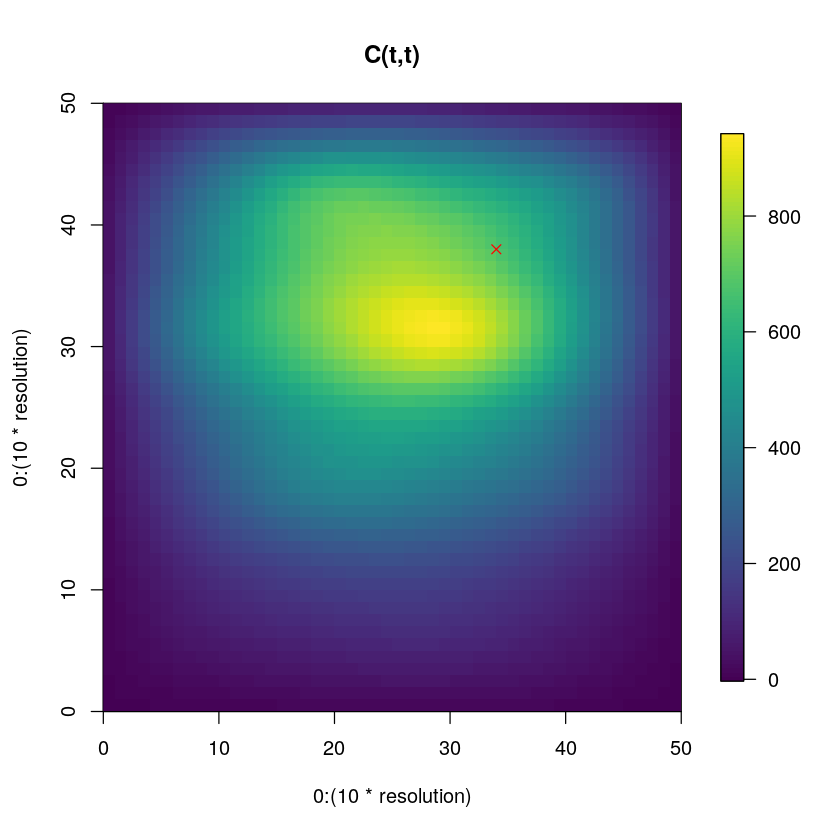

In [58]:
Q=(dx*dy)*t((t(A)%*%A))%*%(t(A)%*%A)
pt=1934
image.plot(0:(10*resolution),0:(10*resolution),matrix(solve(Q)[pt,],nrow=Nx),col=viridis(128),main="C(t,t)")
points(pt%%Nx,floor(pt/Nx),pch=4,col='red')

### III.3.f Spatio-temporal kriging

In [93]:
#### Calcul de la matrice de précision Q
Q=(dx*dy)*t((t(A)%*%A))%*%(t(A)%*%A)
itime=50
indexes_tar = setdiff(1:(Nx*Ny),idD[[itime]])
#### Calcul de la factorisation de Cholesky de QTT
#### On utilisera la fonction Cholesky du package Matrix, et on autorisera les permutations
VTT = Cholesky(Q[indexes_tar,indexes_tar],perm=TRUE,LDL=FALSE)

dat=NULL
dat0=Z_data_all[itime,idD[[itime]]]

Chol=Cholesky(Diagonal(nbNodes)+dt*t(A)%*%A,perm=FALSE,LDL=FALSE)
Prod_   = solve(Diagonal(nbNodes)+dt*t(A)%*%A)
Prod_T_ = solve(Diagonal(nbNodes)+dt*A%*%t(A))

QTD=NULL
for (k in seq(-2,2,1)) {
  Prod = Diagonal(nbNodes)
  if (k<0){
    for(l in seq(k,-1)) {
        Prod = Prod %*% Prod_T_
    }
    Qk = Prod %*% Q 
  }
  else if (k>0){
    for(l in seq(k,1)){
        Prod = Prod %*% Prod_
    }
    Qk =  Q %*% Prod 
  }
  else {
     Qk =  Q    
  }
  #### Sous-matrices QTD de la matrice de précision
  QTDk=Qk[indexes_tar,idD[[itime+k]]]
    
  # column-stack of QTD
  QTD= cbind(QTD,QTDk)
    
  # space-time for kriging
  dat=c(dat,Z_data_all[itime+k,idD[[itime+k]]])
}

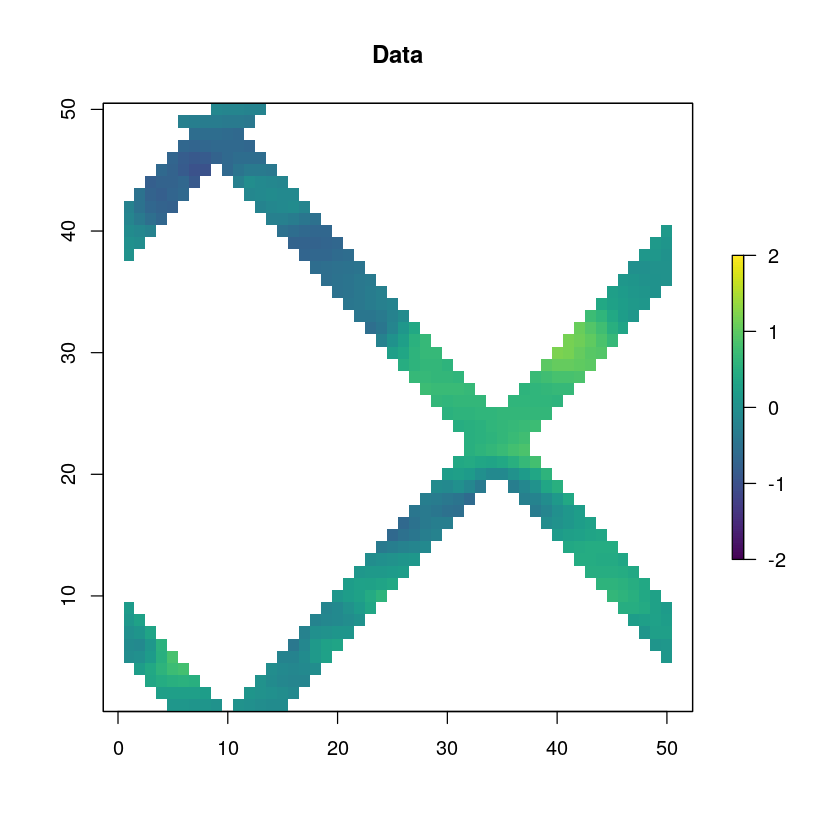

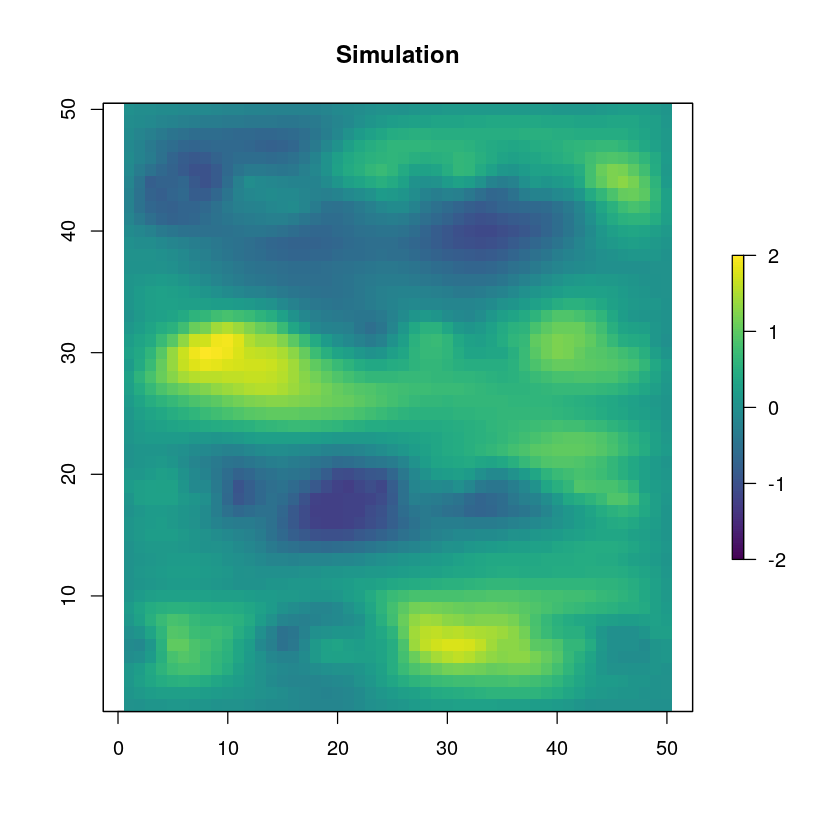

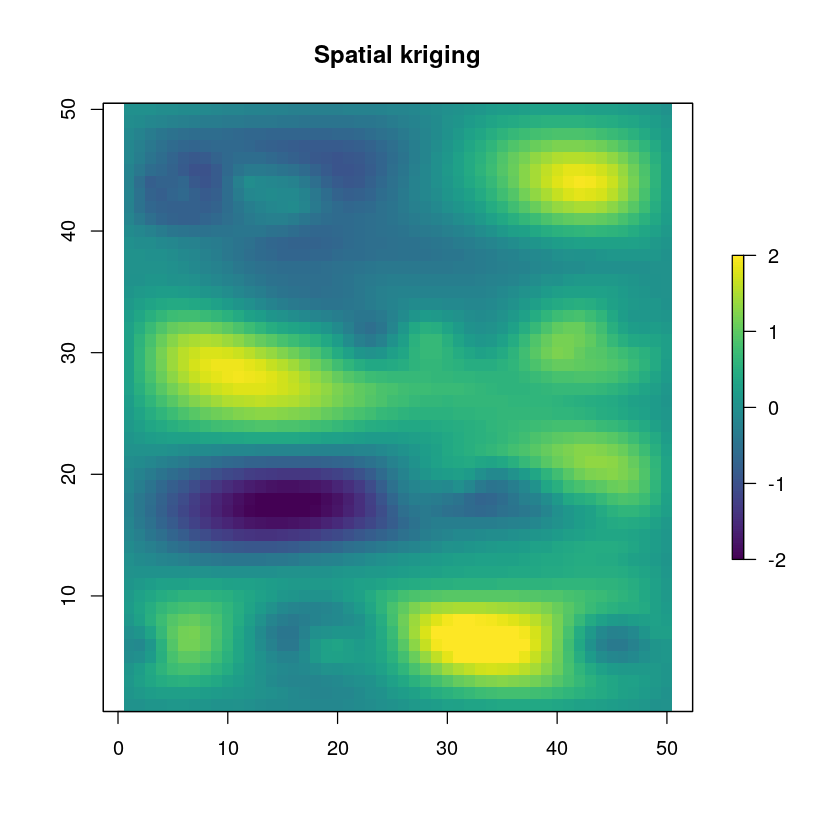

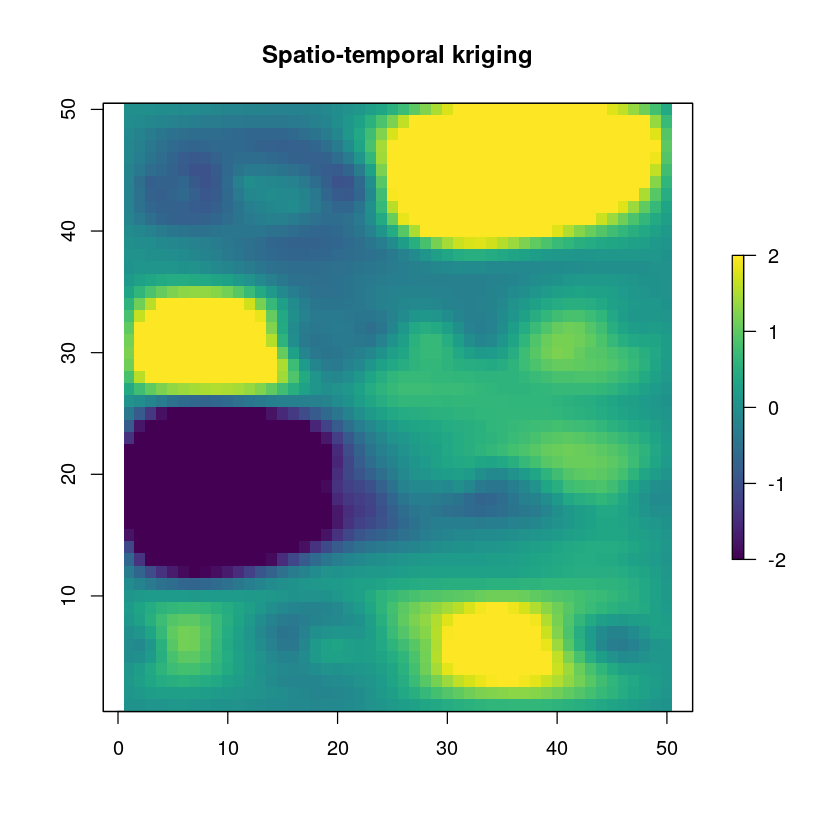

In [94]:
krig_Chol_ST<-function(VTT, QTD,dat,dat0,indexes_dat){
  #### Calcul du second membre
  RM=-QTD%*%dat
  #### Permutation
  RM=expand(VTT)$P%*%RM
  #### Résolution du premier système linéaire
  zT_k =solve(VTT,RM,system="L")
  #### Résolution du second système linéaire
  zT_k =solve(VTT,zT_k,system="Lt")
  #### Permutation inverse
  zT_k = t(expand(VTT)$P)%*%zT_k
  #### Mise en forme du vecteur
  nbNodes=dim(QTD)[1]+length(dat0)
  z_k=rep(NA,nbNodes)
  z_k[indexes_dat]=dat0
  z_k[-indexes_dat]=zT_k
  return(z_k)
}

#### Krigeage de la simulation non conditionnelle
z_k_ST=krig_Chol_ST(VTT,QTD,dat,dat0,idD[[itime]])
znc=Z_all[itime,]
spplot(matrix(Z_data_all[itime,],nrow=Nx),zlim=c(-2,2),title='Data')
spplot(matrix(znc,nrow=Nx),zlim=c(-2,2),title='Simulation')
spplot(matrix(z_k_S,nrow=Nx),zlim=c(-2,2),title='Spatial kriging')
spplot(matrix(z_k_ST,nrow=Nx),zlim=c(-2,2),title='Spatio-temporal kriging')

### III.3.e Spatio-temporal conditional simulation

#### III.3.e.1  Run a second spatio-temporal simulation

In [95]:
# Spatio-temporal simulation 
Z=rnorm(nbNodes,0,tau)
Z2_all=matrix(NA,nrow=nbIter, ncol=nbNodes)
for(i in 1:nbIter){ 
  RM=sqrt(dt/(dx*dy))*rnorm(nbNodes,0,tau)+Z
  RM=(expand(AspChol)$P)%*%RM
  Z=solve(AspChol, RM,system="L")
  Z=solve(AspChol, Z,system="Lt")
  Z=t(expand(AspChol)$P)%*%Z
  Z2_all[i,]=Z
}

# Extract simulation at data locations
Z2_data_all=Z2_all
for(i in 1:nbIter){
    indexes_dat=NULL
    for (j in 1:Ny){
        indexes_dat=c(indexes_dat,((Nx*(j-1))+10+j+(10*i%%Nx)):(((Nx*(j-1))+10+j+(10*i%%Nx)+4)))
        indexes_dat=c(indexes_dat,((Nx*(j-1))+10-j-(10*i%%Nx)):(((Nx*(j-1))+10-j-(10*i%%Nx)-4)))
    }
    indexes_dat=unique(indexes_dat[which(indexes_dat<=(Nx*Ny) & indexes_dat>0)])
    Z2_data_all[i,-indexes_dat]=NA
}

#### III.3.e.2  simulation (time=50) 

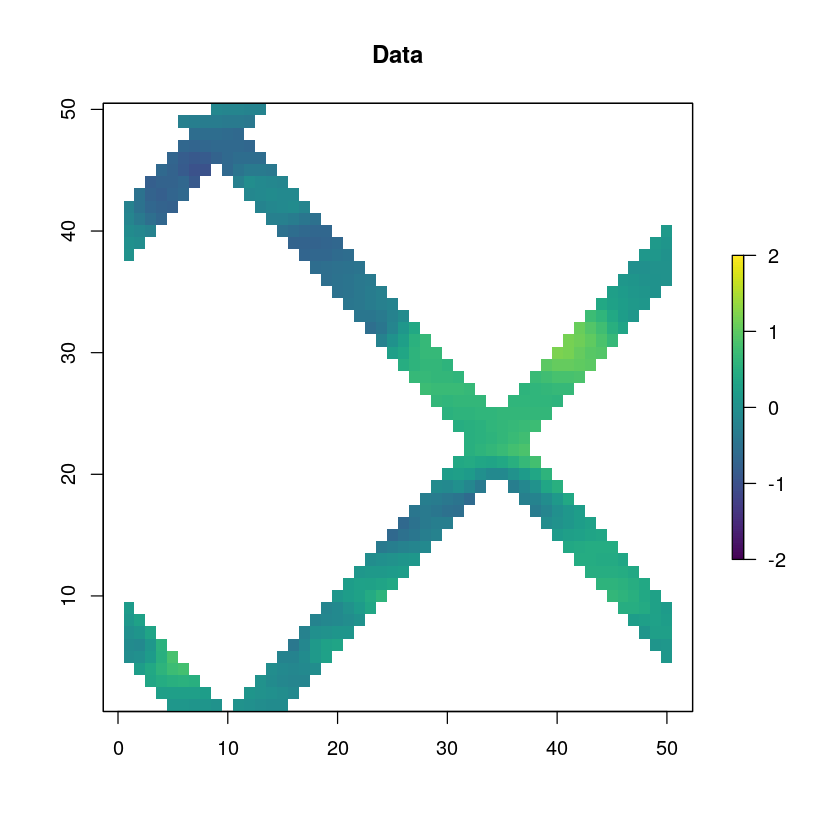

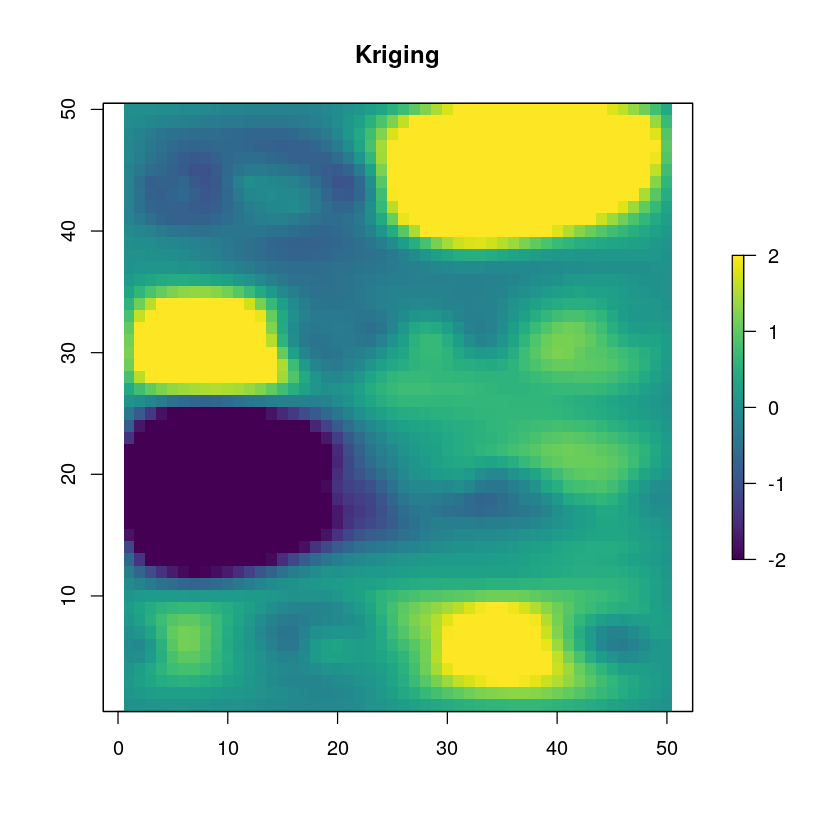

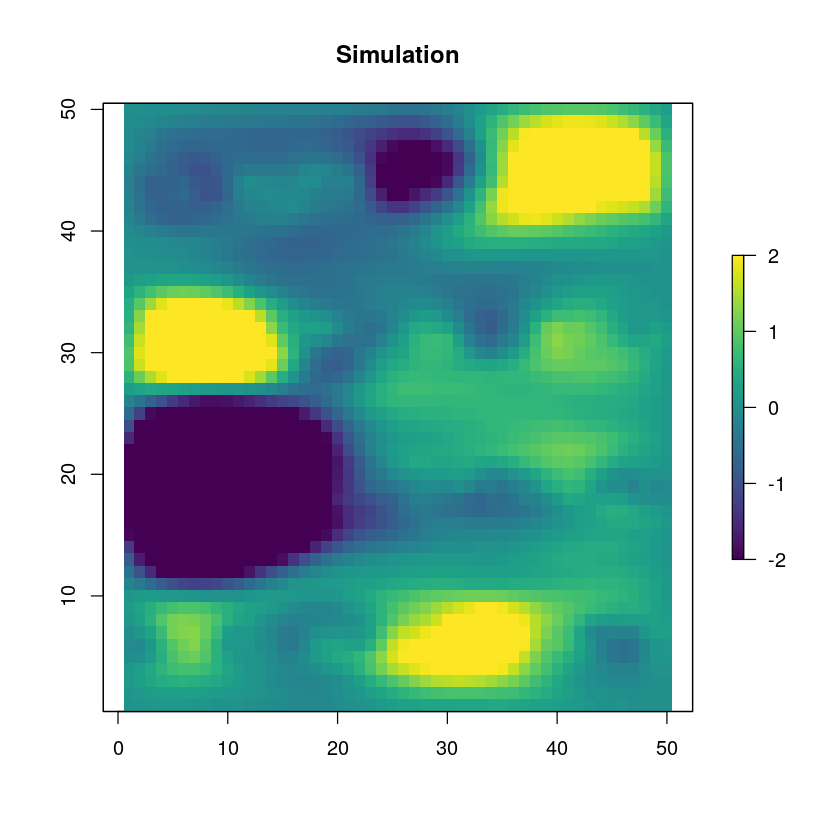

In [99]:
itime=50
dat2=NULL
dat2_0=Z2_data_all[itime,idD[[itime]]]
for (k in seq(-2,2,1)) {
  dat2=c(dat2,Z2_data_all[itime+k,idD[[itime+k]]])
}

#### Généner une simulation non conditionnelle
znc=Z2_all[itime,]
#### Krigeage des données
z_k=krig_Chol_ST(VTT,QTD,dat,dat0,idD[[itime]])
#### Simulation conditionnelle
znc_k=krig_Chol_ST(VTT,QTD,dat2,dat2_0,idD[[itime]])
zc=z_k+(znc-znc_k)
# ----------------------------------------------------------------------------------------- #
######### Affichage du résultat
spplot(matrix(Z_data_all[itime,],nrow=Nx),zlim=c(-2,2),title='Data')
spplot(matrix(z_k,nrow=Nx),zlim=c(-2,2),title='Kriging')
spplot(matrix(zc,nrow=Nx),zlim=c(-2,2),title='Simulation')

# IV. Writing outputs in a NetCDF file

In [118]:
library(ncdf4)

filename=paste0("./datasets/adv_diff_dataset_",10*resolution,".nc")

xvals <- seq(1,Nx)
yvals <- seq(1,Ny) 
nx <- length(xvals)
ny <- length(yvals)
lon1 <- ncdim_def("longitude", "degrees_east", xvals)
lat2 <- ncdim_def("latitude", "degrees_north", yvals)
time <- ncdim_def("Time","days", 1:nbIter, unlim=TRUE)

mv <- -999 # missing value to use
var_temp <- ncvar_def("x", "no units", list(lon1,lat2,time), longname="True SPDE-based field", mv) 
var_temp_miss <- ncvar_def("y", "no units", list(lon1,lat2,time), longname="observations", mv) 
H11_temp  <- ncvar_def("H11", "no units", list(lon1,lat2), longname="H11 tensor", mv) 
H22_temp  <- ncvar_def("H22", "no units", list(lon1,lat2), longname="H22 tensor", mv) 
H12_temp  <- ncvar_def("H12", "no units", list(lon1,lat2), longname="H12 tensor", mv) 
kappa_temp  <- ncvar_def("kappa", "no units", list(lon1,lat2), longname="kappa scalar", mv)

ncnew <- nc_create(filename, list(var_temp, var_temp_miss,
                                  H11_temp, H22_temp, H12_temp,
                                  kappa_temp),force_v4=TRUE)
x = aperm(array(as.vector(Z_all),c(nbIter,Nx,Ny)),c(2,3,1))
ncvar_put(ncnew, var_temp, x, start=c(1,1,1), count=c(nx,ny,nbIter))
x_miss=aperm(array(as.vector(Z_data_all),c(nbIter,Nx,Ny)),c(2,3,1))
ncvar_put(ncnew, var_temp_miss, x_miss, start=c(1,1,1), count=c(nx,ny,nbIter))
ncvar_put(ncnew, H11_temp, matrix(Hs[1,1,],nrow=Nx), start=c(1,1), count=c(nx,ny))
ncvar_put(ncnew, H22_temp, matrix(Hs[1,2,],nrow=Nx), start=c(1,1), count=c(nx,ny))
ncvar_put(ncnew, H12_temp, matrix(Hs[2,2,],nrow=Nx), start=c(1,1), count=c(nx,ny))
ncvar_put(ncnew, kappa_temp, matrix(kappa,nrow=Nx,ncol=Ny), start=c(1,1), count=c(nx,ny))

nc_close(ncnew)